# implement iterative identification of Ly$\alpha$ absorption

In [1]:
import os
import pickle
import numpy as np

import torch

In [2]:
from spenderq import util, load_model
from spenderq import lyalpha as LyA

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
print("torch.cuda.device_count():",torch.cuda.device_count())

torch.cuda.device_count(): 0


/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.pt')

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [6]:
ibatch = 0 
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [7]:
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

In [8]:
with torch.no_grad():
    models[0].eval()

    s = models[0].encode(spec)
    spec_rest = models[0].decode(s)

# 0. check out preformance for far

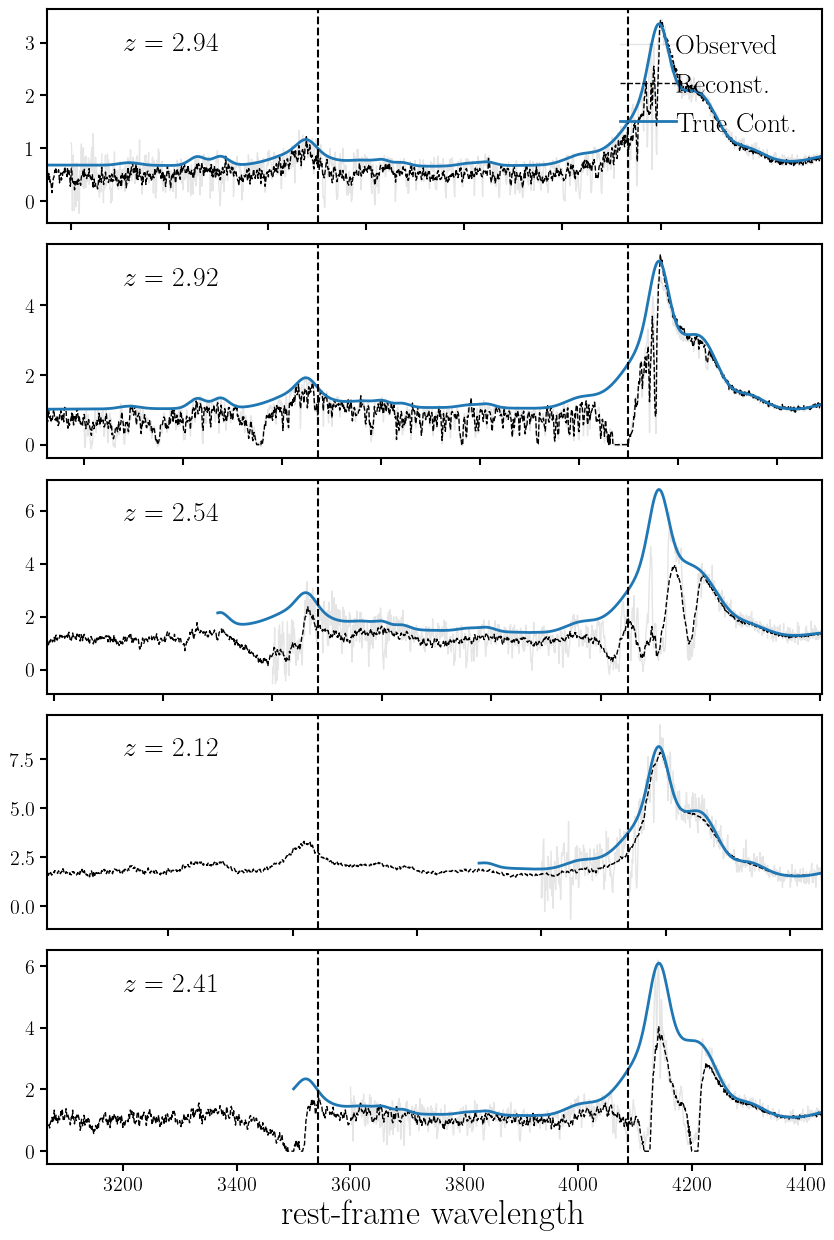

In [9]:
fig = plt.figure(figsize=(10,15))
for ii, igal in enumerate(np.random.choice(np.arange(len(spec))[np.array(norm) > 4.], size=5, replace=False)): 
    sub = fig.add_subplot(5,1,ii+1)
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='k', lw=1, ls='--', label='Reconst.')
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    #sub.plot(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', alpha=0.5, lw=1, label='Observed')    
    #sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r')
    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)

    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    if ii < 4: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

# 1. Identify LyA absorption region

/tmp/ipykernel_1568884/378085267.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sub.scatter(models[0].wave_obs[(w[igal] == 0) | is_absorb], spec[igal][(w[igal] == 0) | is_absorb], c='r', s=2)
/tmp/ipykernel_1568884/378085267.py:14: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sub.scatter(models[0].wave_obs[(w[igal] == 0) | is_absorb], spec[igal][(w[igal] == 0) | is_absorb], c='r', s=2)
/home/chhahn/projects/SpenderQ/src/spenderq/lyalpha.py:42: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * ivar_coarse[~below_lya]**-0.5)
/tmp/ipykernel_1568884/378085267.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future

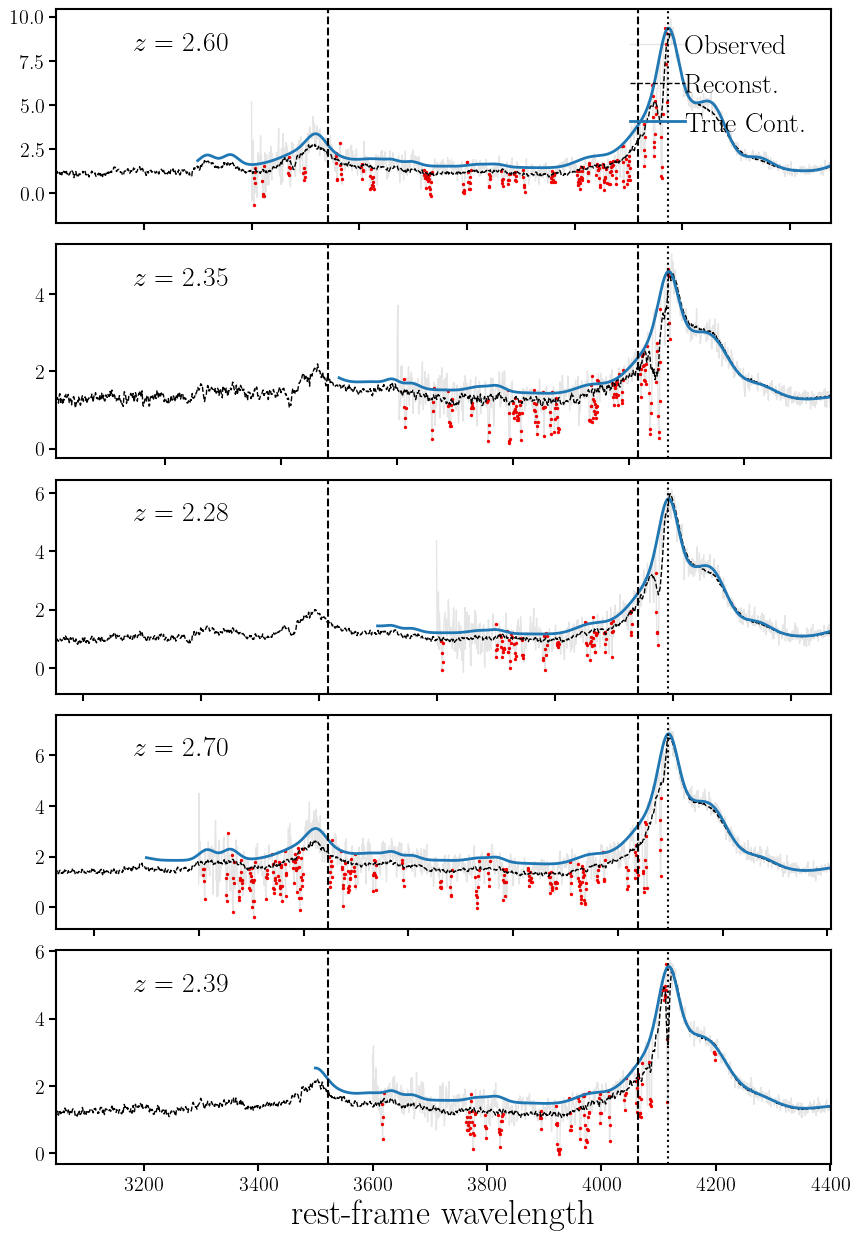

In [15]:
fig = plt.figure(figsize=(10,15))
for ii, igal in enumerate(np.random.choice(np.arange(len(spec))[np.array(norm) > 4.], size=5, replace=False)): 
    sub = fig.add_subplot(5,1,ii+1)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='k', lw=1, ls='--', label='Reconst.')
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    is_absorb = LyA.identify_LyA(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), sigma=1.5, method='rebin')
    
    #sub.scatter(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', s=1)    
    sub.scatter(models[0].wave_obs[(w[igal] == 0) | is_absorb], spec[igal][(w[igal] == 0) | is_absorb], c='r', s=2)
    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)

    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    if ii < 4: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

# 3. deploy on batches

BATCH 19
tensor(3.5615e+08)


<ipython-input-17-7eccb29a0609>:26: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * ivar_coarse[~below_lya]**-0.5)
<ipython-input-22-bffd2d15493f>:42: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sub.plot(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', alpha=0.5, lw=1, label='Observed')
<ipython-input-22-bffd2d15493f>:43: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sub.scatter(models[0].wave_obs[(w[igal] == 0) | is_absorb], spec[igal][(w[igal] == 0) | is_absorb], c='r', s=2)


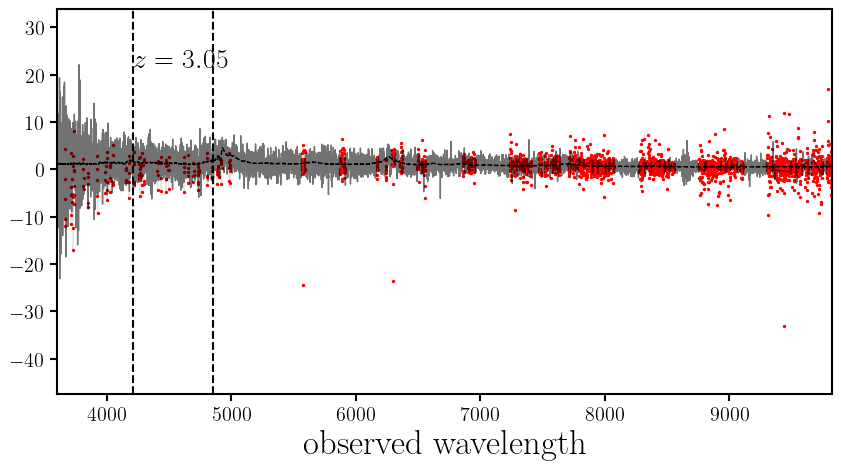

tensor(3.5088e+08)
BATCH 20
tensor(2.3297e+08)


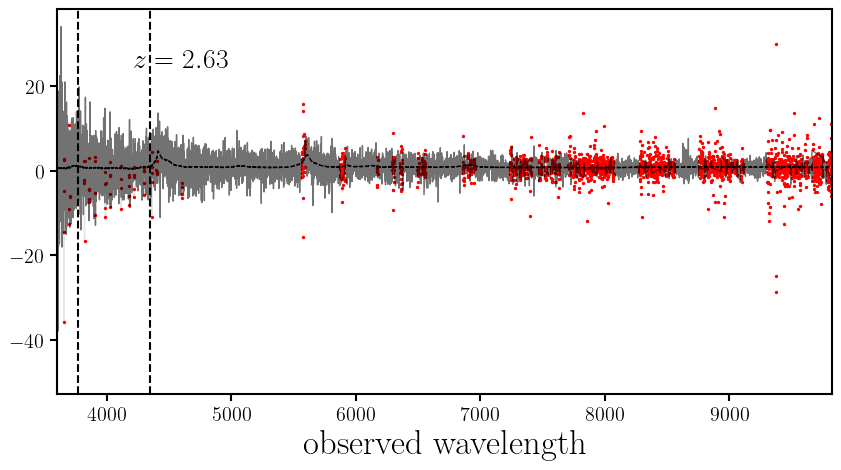

tensor(2.2983e+08)
BATCH 21
tensor(1.8624e+08)


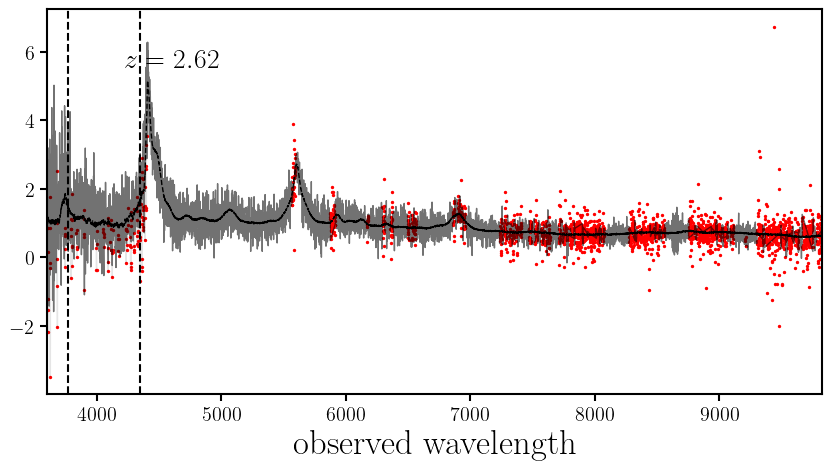

tensor(1.8364e+08)
BATCH 22
tensor(3.5468e+08)


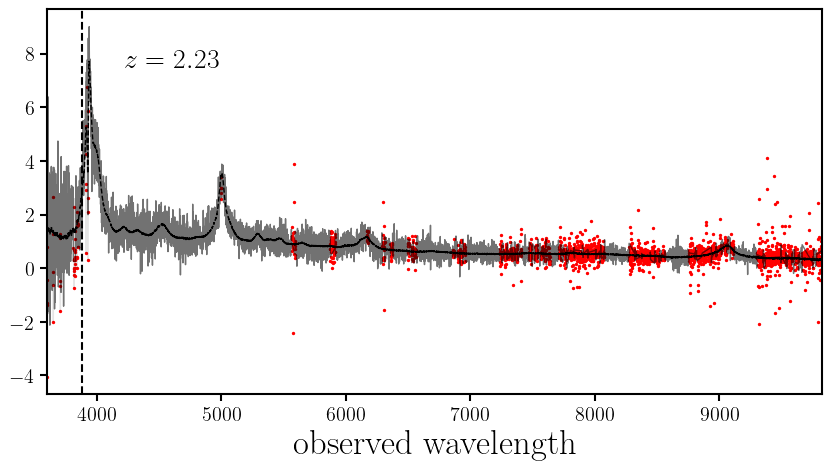

tensor(3.4218e+08)
BATCH 23
tensor(4.0646e+08)


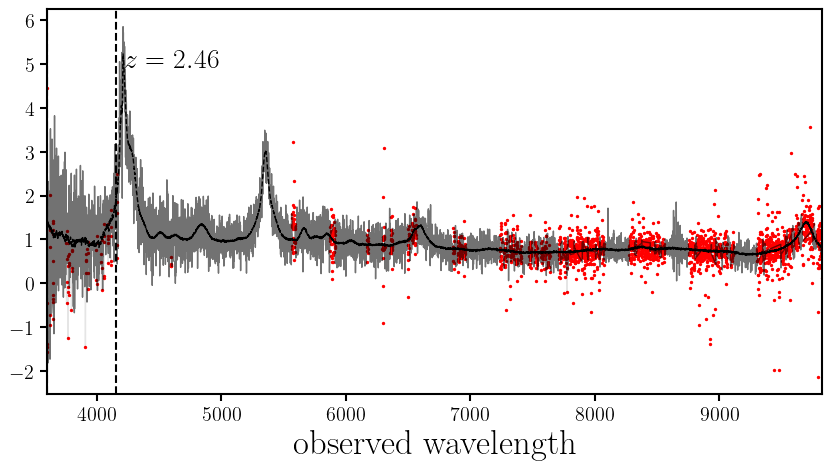

tensor(3.9522e+08)
BATCH 24
tensor(4.2871e+08)


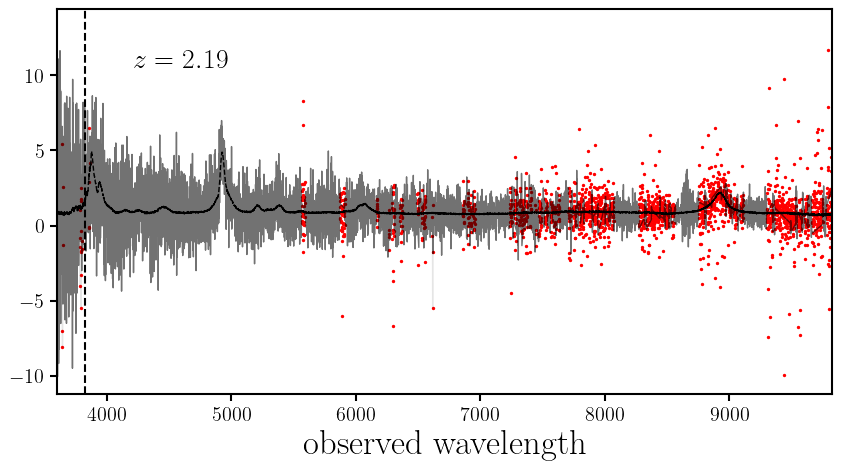

tensor(4.2078e+08)
BATCH 25
tensor(1.6985e+08)


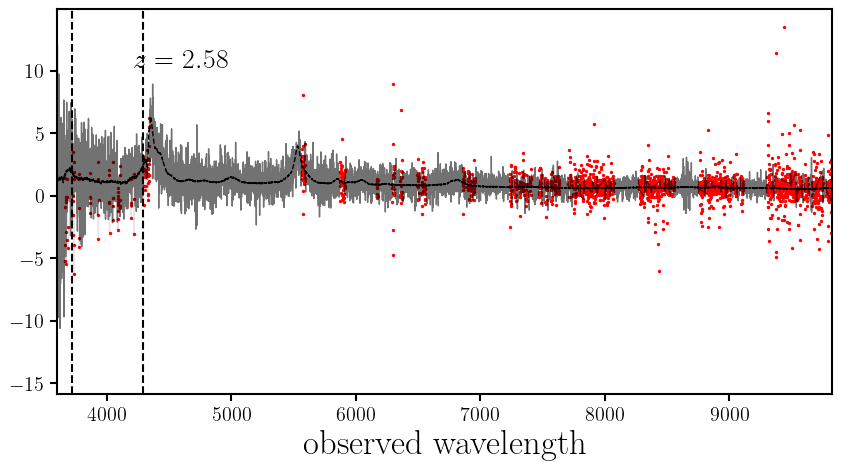

tensor(1.6709e+08)
BATCH 26
tensor(1.6258e+08)


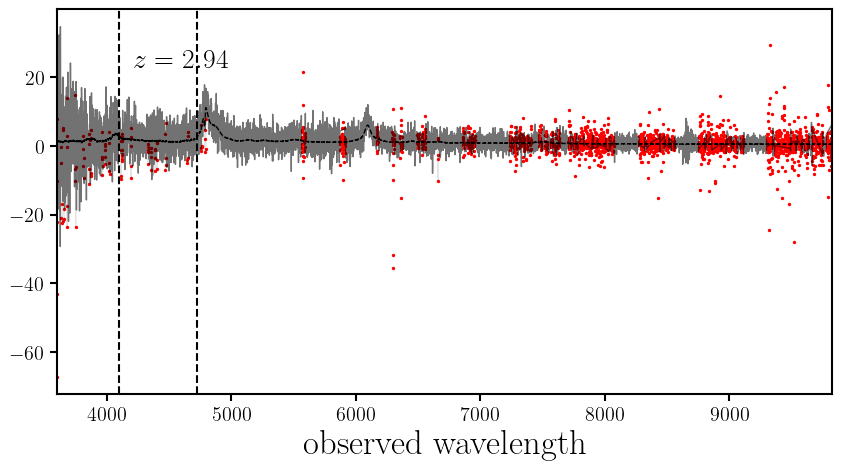

tensor(1.6130e+08)
BATCH 27
tensor(3.7982e+08)


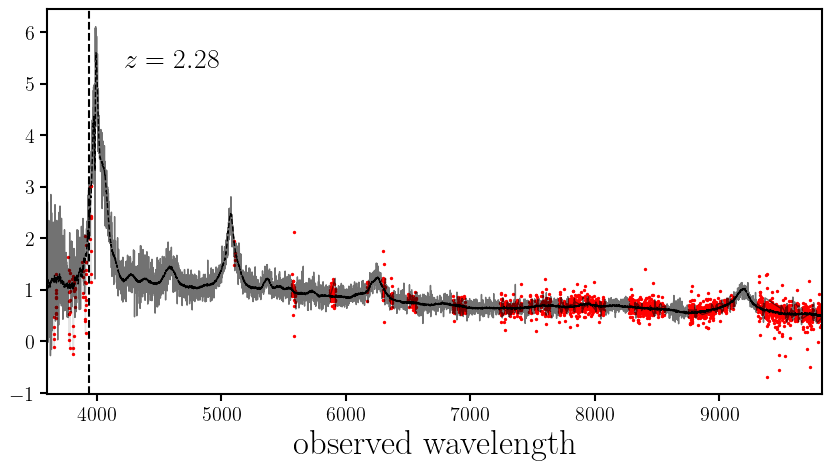

tensor(3.7242e+08)
BATCH 28
tensor(4.0103e+08)


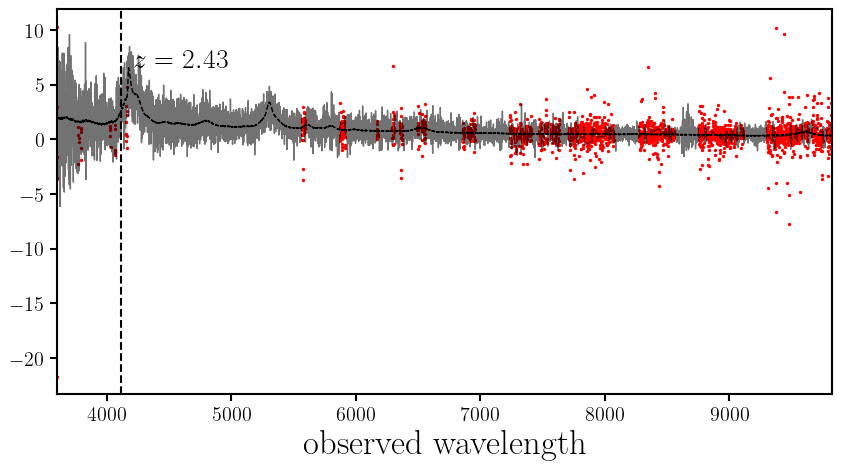

tensor(3.9296e+08)
BATCH 29
tensor(2.2591e+08)


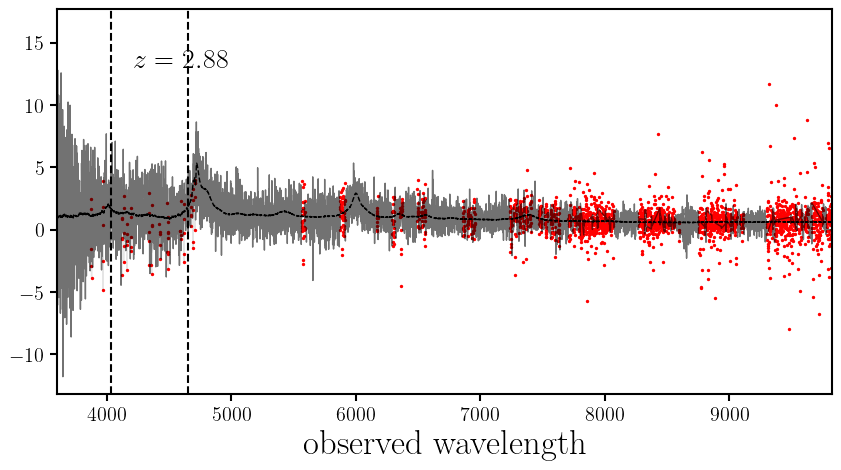

tensor(2.2231e+08)
BATCH 30
tensor(2.1365e+08)


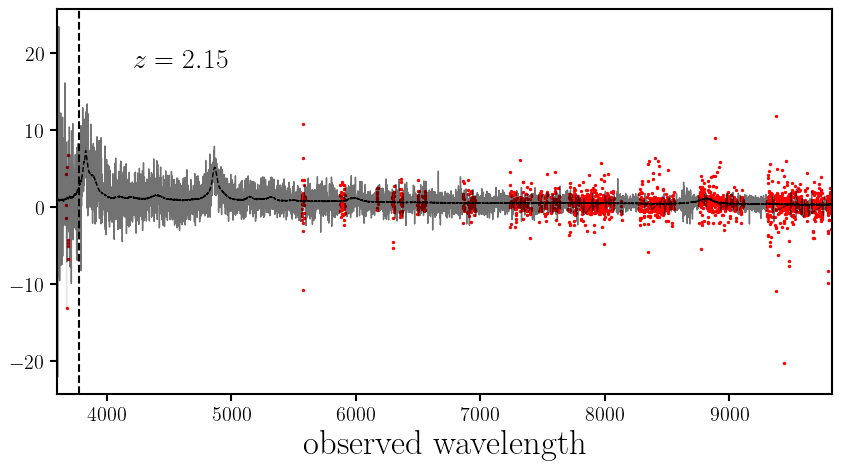

tensor(2.1050e+08)
BATCH 31
tensor(3.9096e+08)


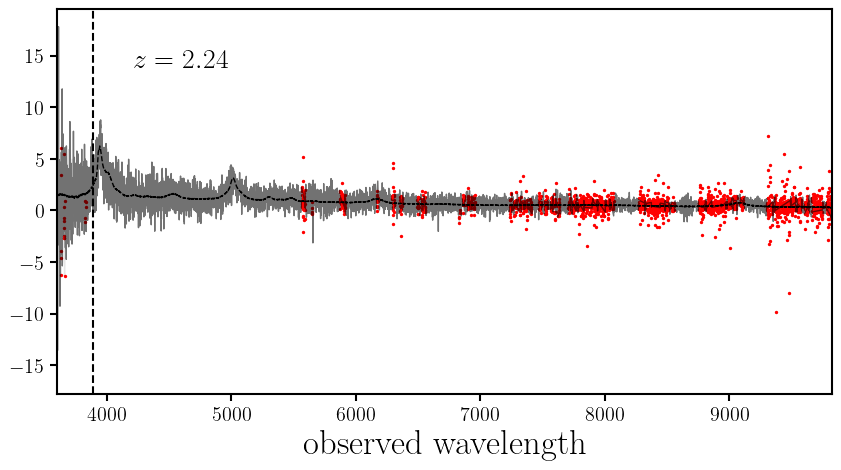

tensor(3.8477e+08)
BATCH 32
tensor(3.9448e+08)


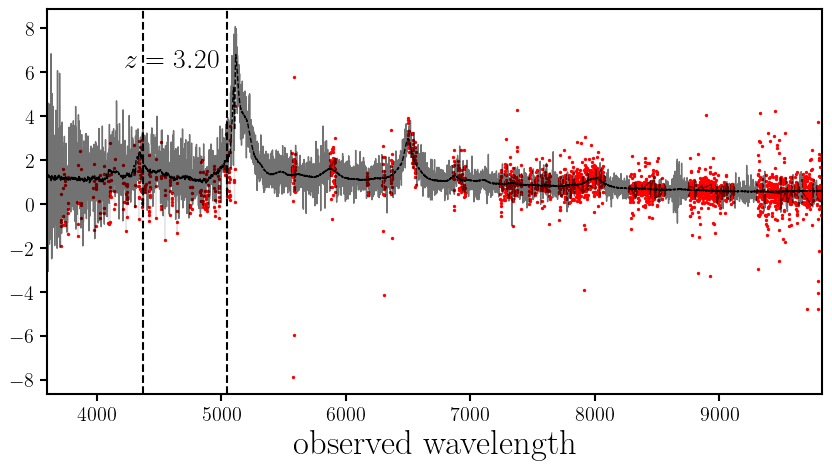

tensor(3.8931e+08)
BATCH 33
tensor(3.6560e+08)


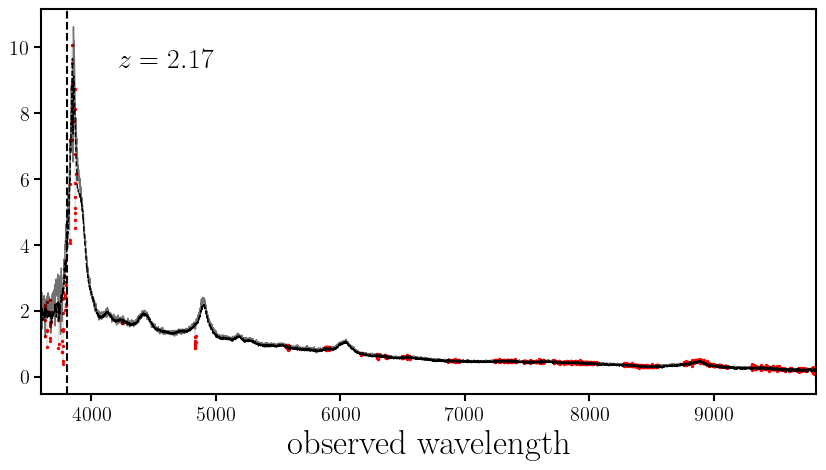

tensor(3.5749e+08)
BATCH 34
tensor(2.3104e+08)


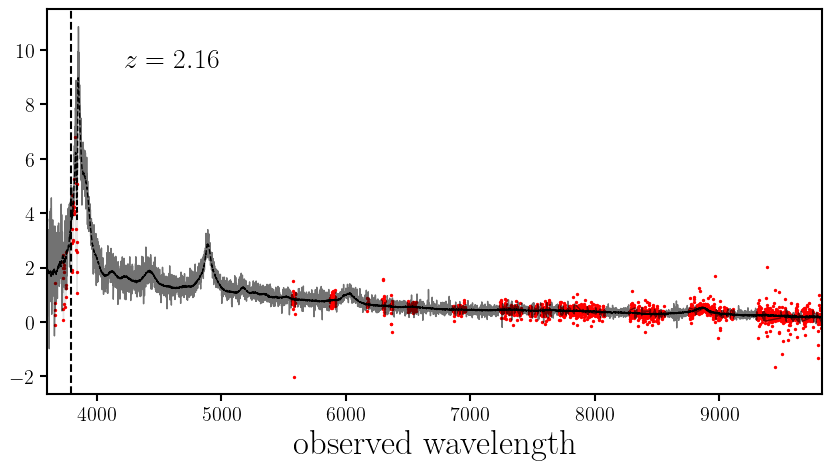

tensor(2.2904e+08)
BATCH 35
tensor(1.6675e+08)


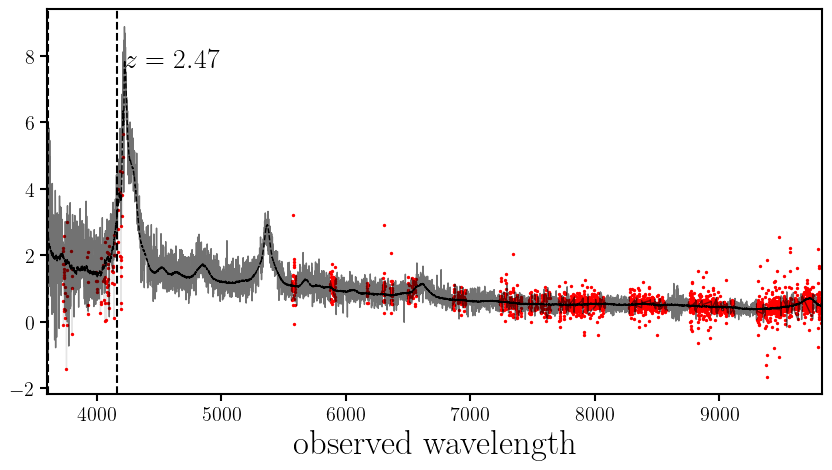

tensor(1.6540e+08)
BATCH 36
tensor(1.4156e+08)


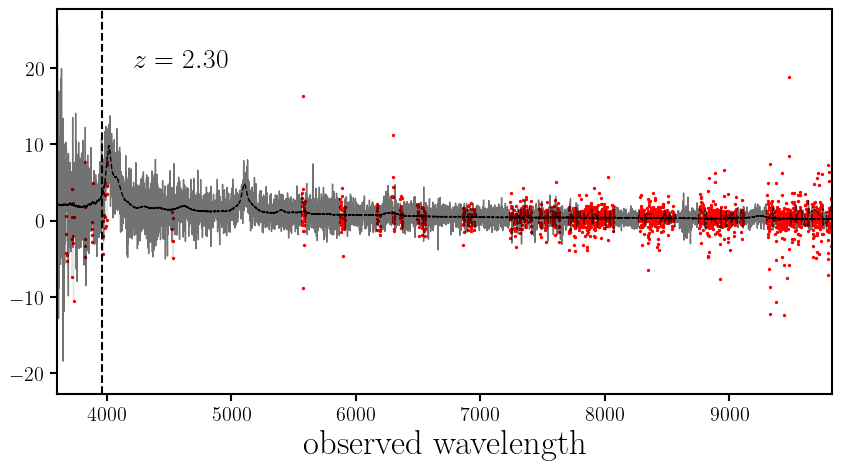

tensor(1.4037e+08)
BATCH 37
tensor(3.2832e+08)


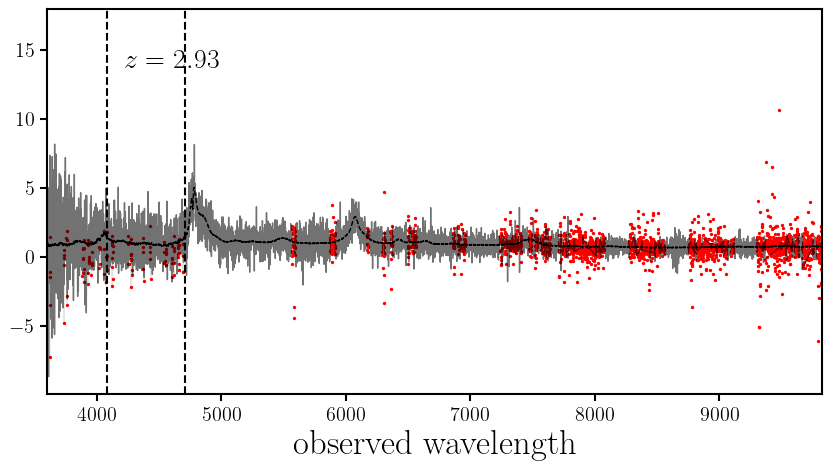

tensor(3.2176e+08)
BATCH 38
tensor(2.1405e+08)


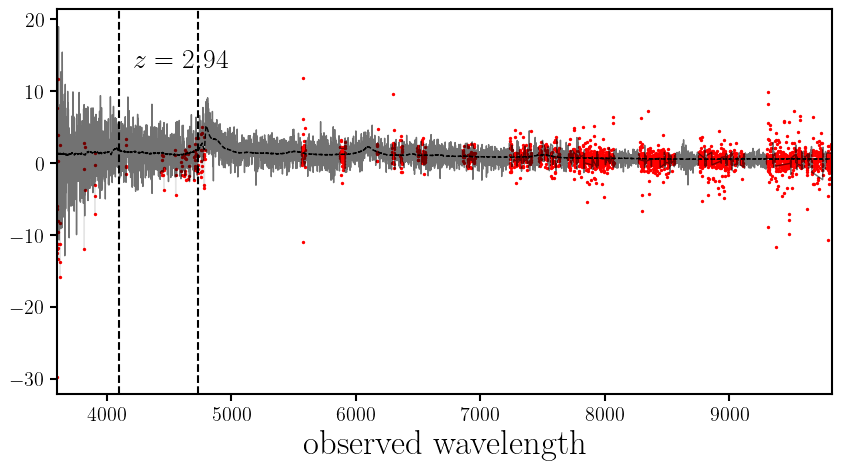

tensor(2.1126e+08)
BATCH 39
tensor(1.3989e+08)


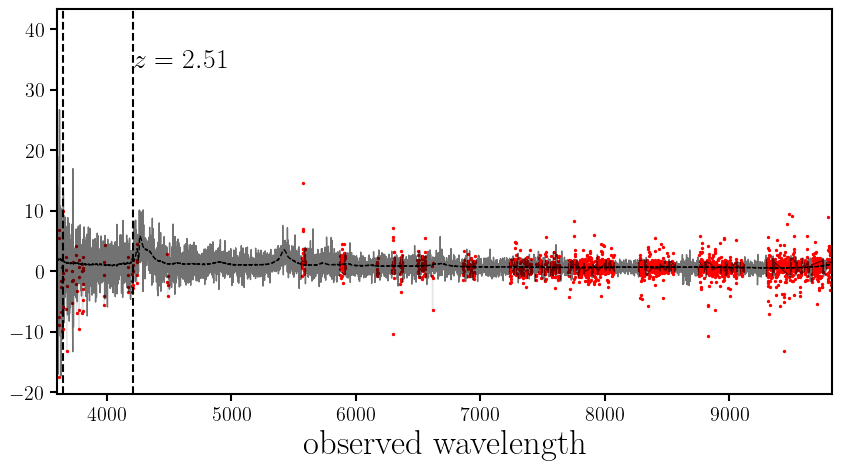

tensor(1.3863e+08)
BATCH 40
tensor(2.0845e+08)


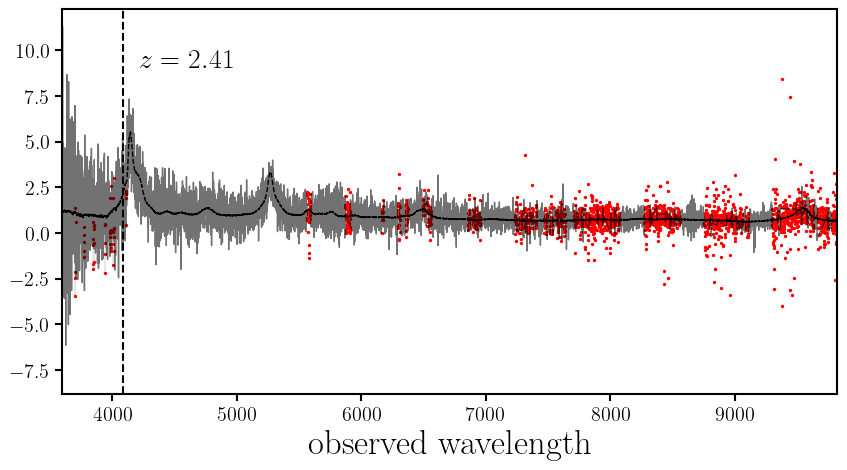

tensor(2.0662e+08)
BATCH 41
tensor(2.0710e+08)


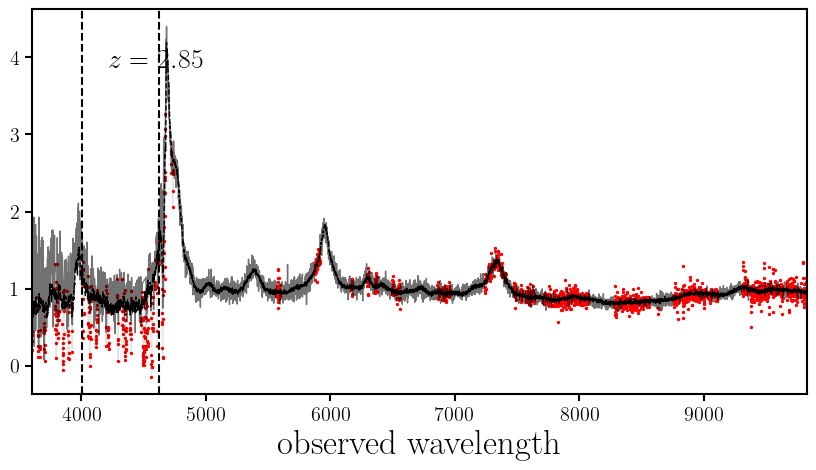

tensor(2.0485e+08)
BATCH 42
tensor(1.5133e+08)


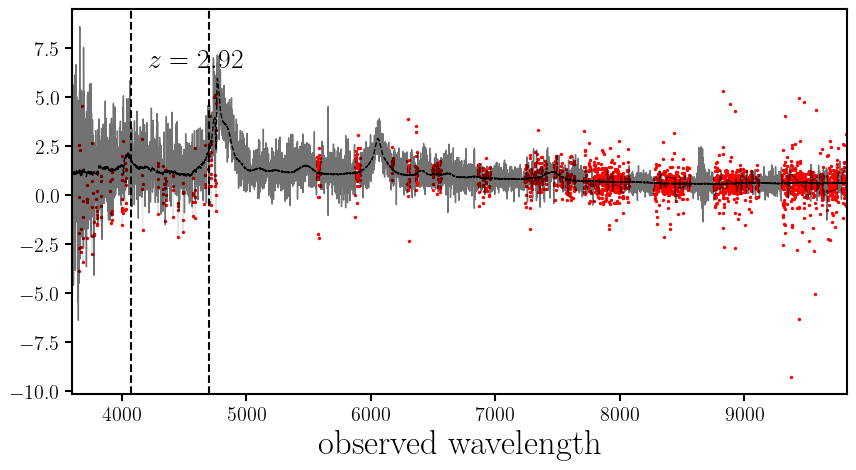

tensor(1.4988e+08)
BATCH 43
tensor(2.6890e+08)


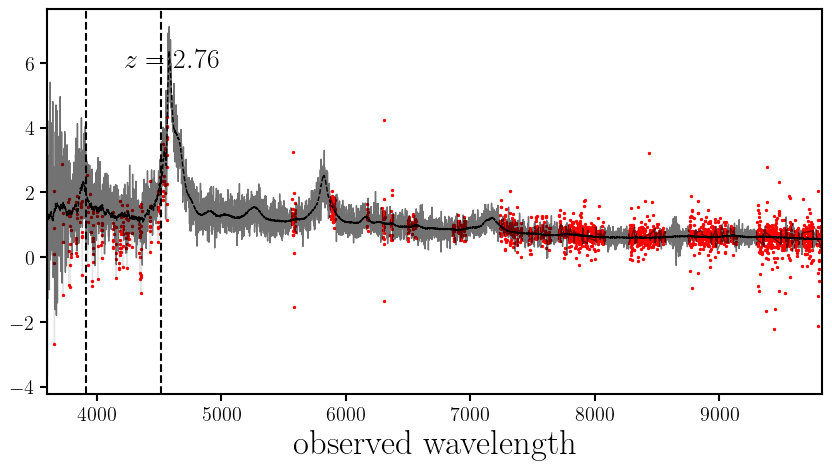

tensor(2.6591e+08)
BATCH 44
tensor(1.4847e+08)


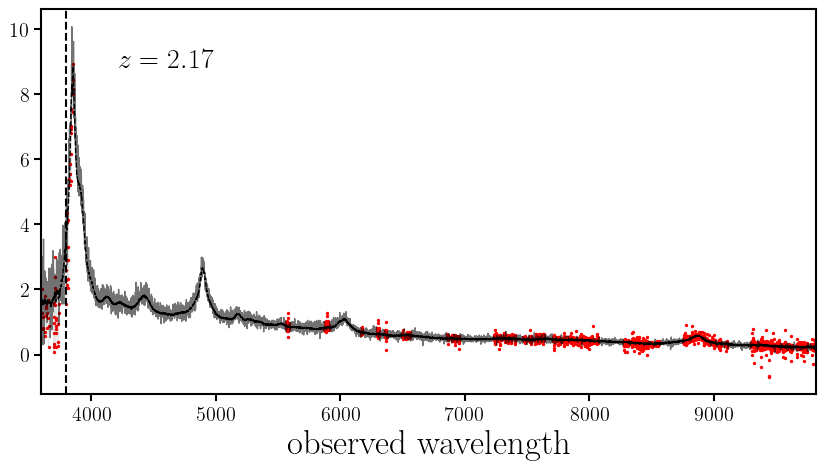

tensor(1.4681e+08)
BATCH 45
tensor(2.2404e+08)


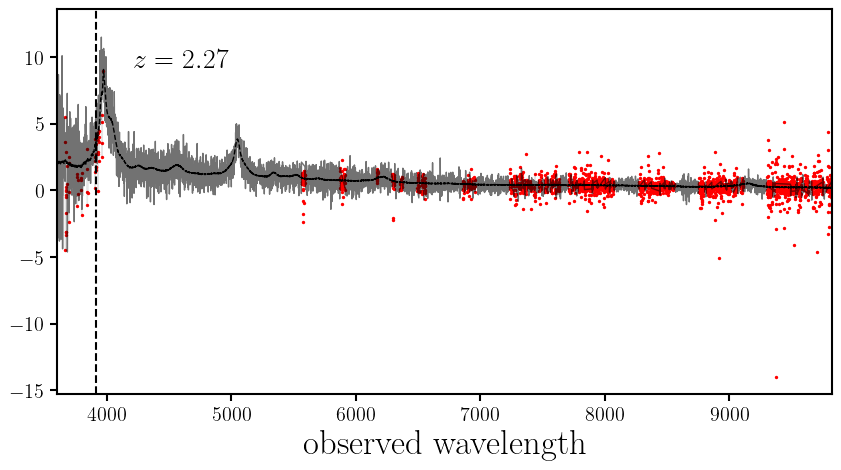

tensor(2.2078e+08)
BATCH 46
tensor(2.0722e+08)


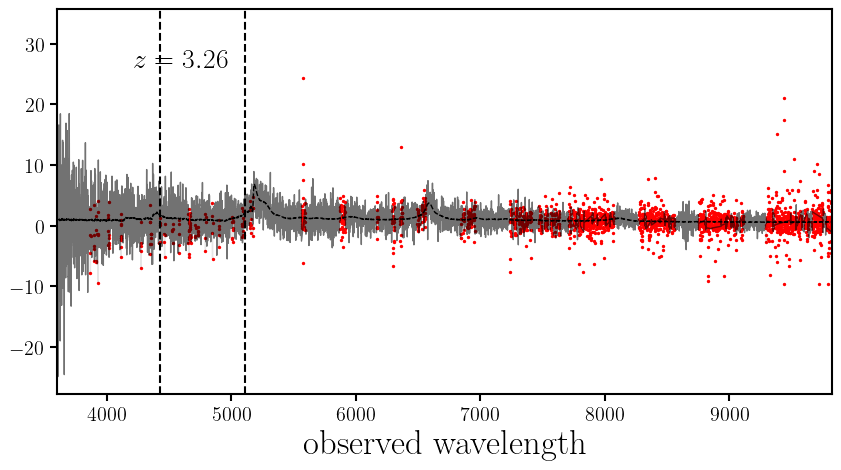

tensor(2.0428e+08)
BATCH 47
tensor(2.6389e+08)


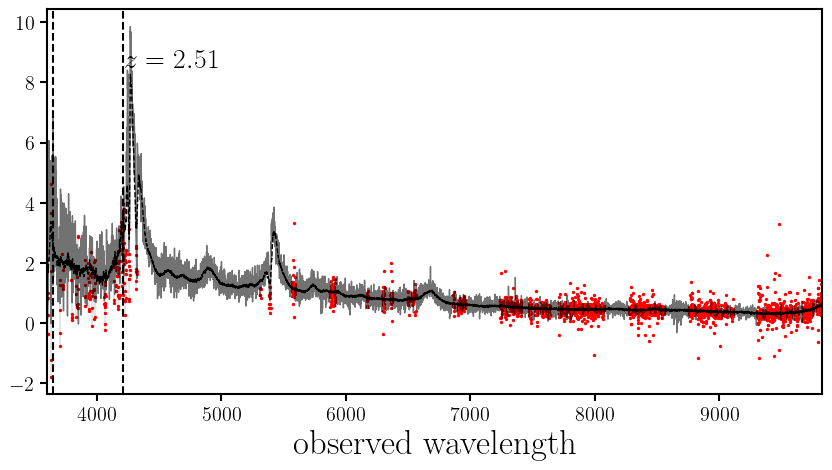

tensor(2.6135e+08)
BATCH 48
tensor(3.1391e+08)


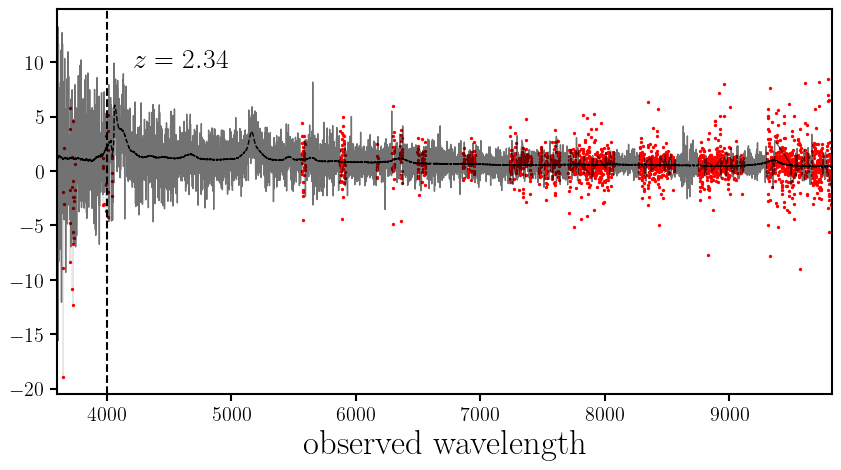

tensor(3.0743e+08)
BATCH 49
tensor(2.1871e+08)


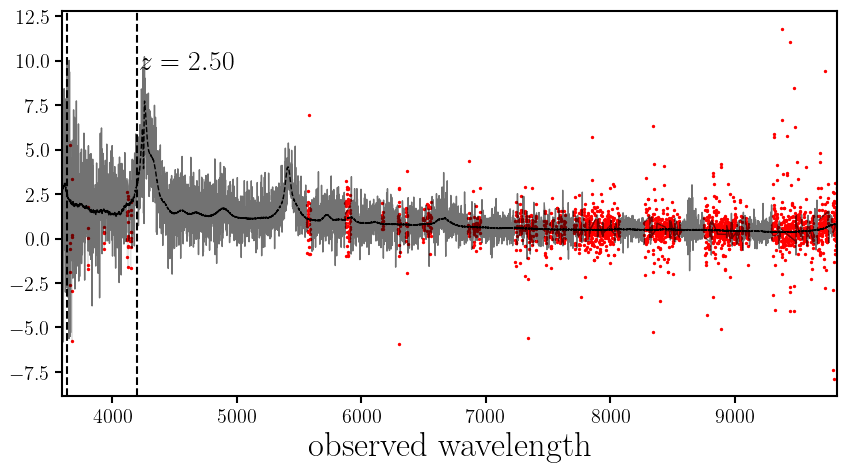

tensor(2.1589e+08)
BATCH 50
tensor(1.6164e+08)


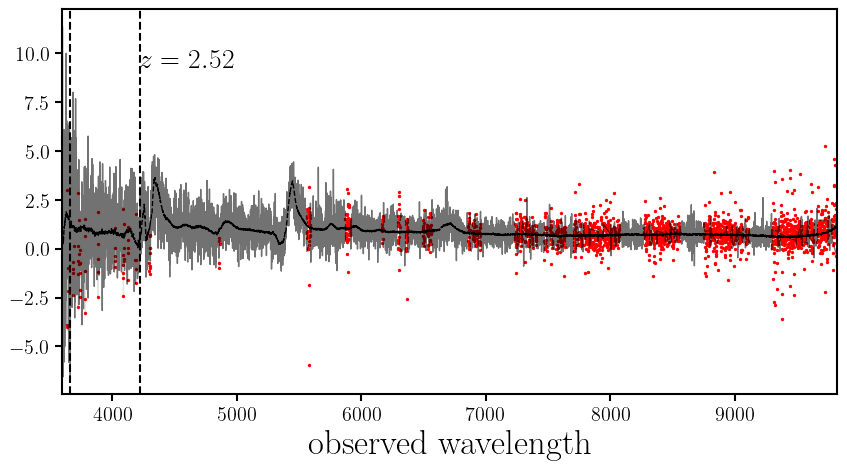

tensor(1.6066e+08)
BATCH 51
tensor(1.4923e+08)


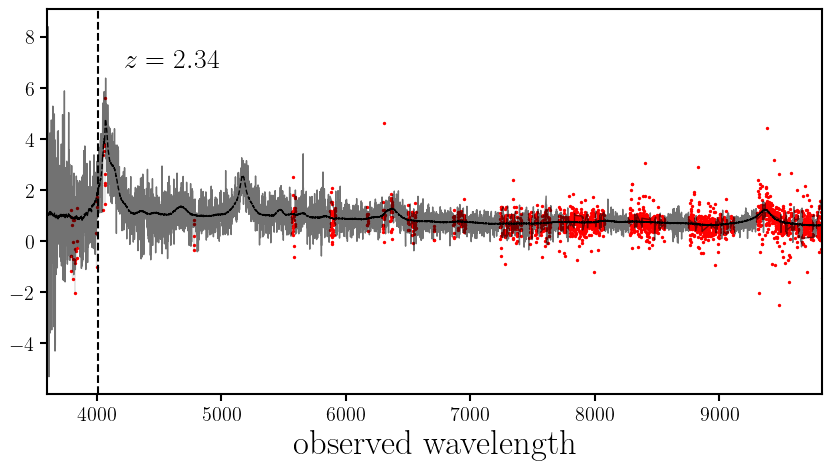

tensor(1.4724e+08)
BATCH 52
tensor(1.5883e+08)


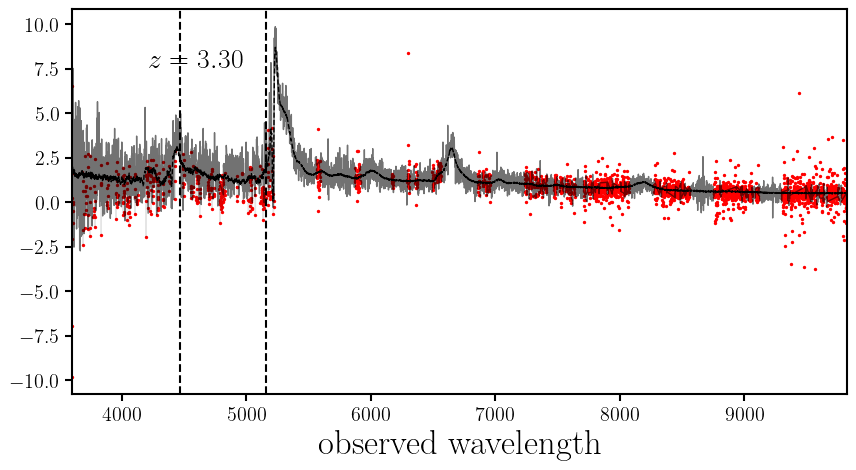

tensor(1.5737e+08)
BATCH 53
tensor(1.6547e+08)


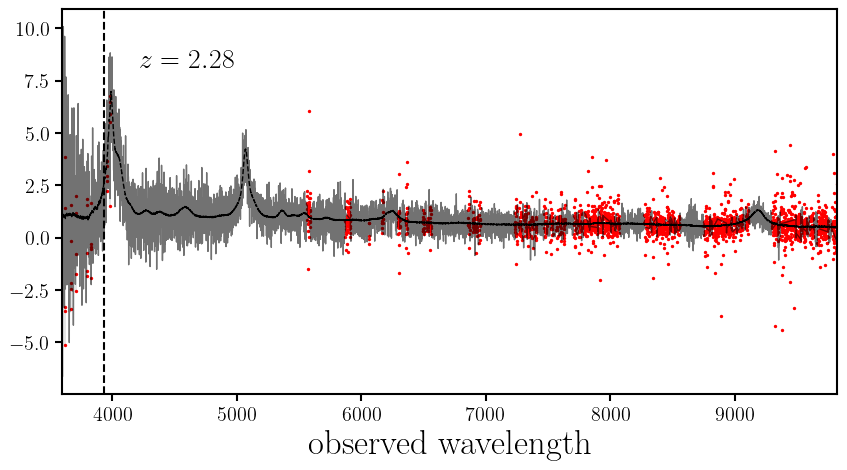

tensor(1.6378e+08)
BATCH 54
tensor(2.3037e+08)


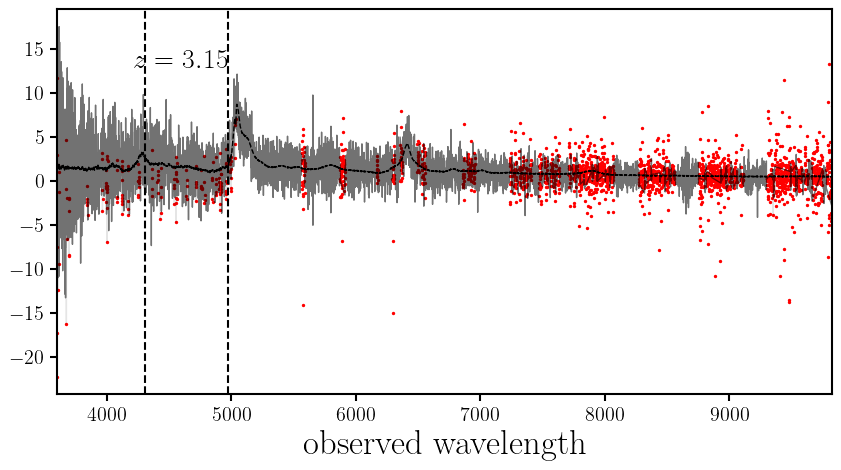

tensor(2.2674e+08)
BATCH 55
tensor(2.5799e+08)


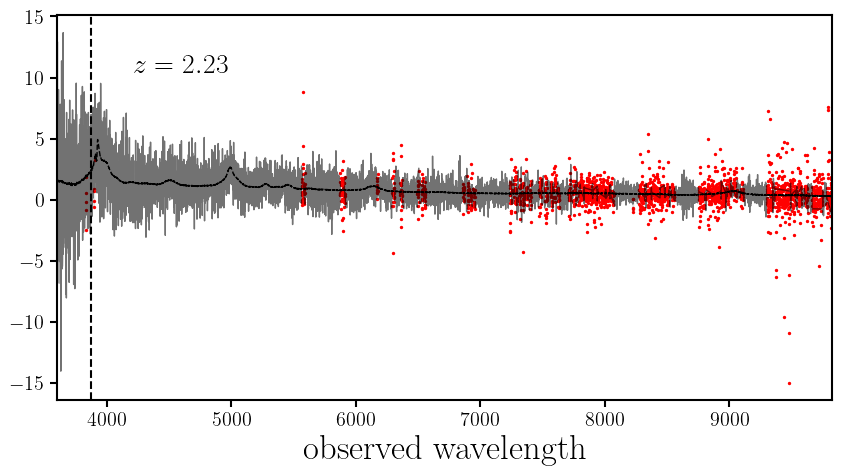

tensor(2.5490e+08)
BATCH 56
tensor(2.0035e+08)


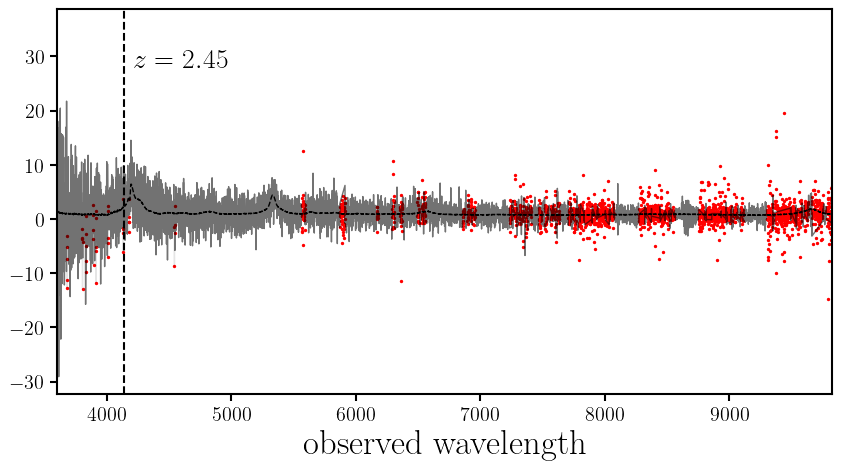

tensor(1.9853e+08)
BATCH 57
tensor(2.8518e+08)


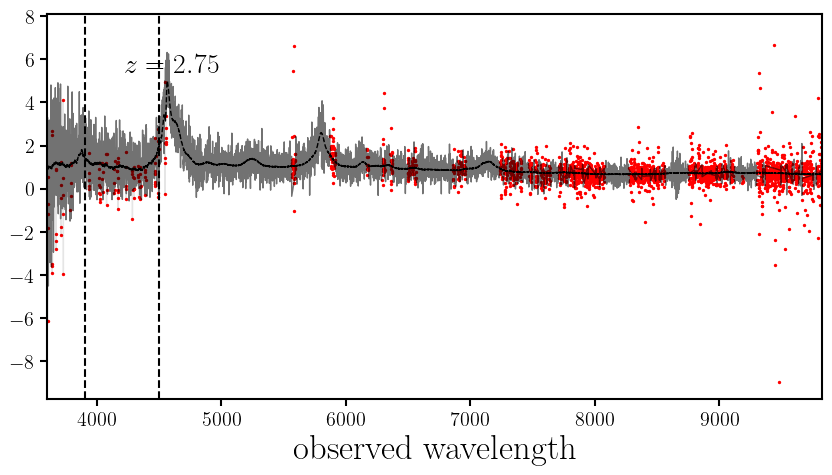

tensor(2.7981e+08)
BATCH 58
tensor(1.9351e+08)


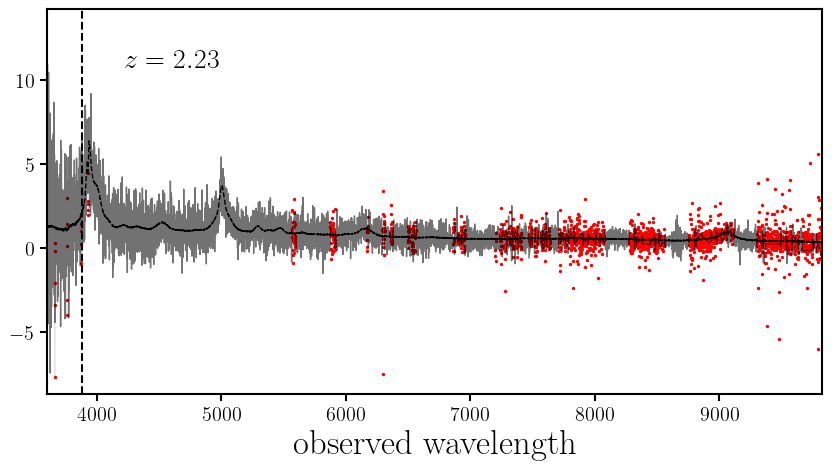

tensor(1.9069e+08)
BATCH 59
tensor(2.1203e+08)


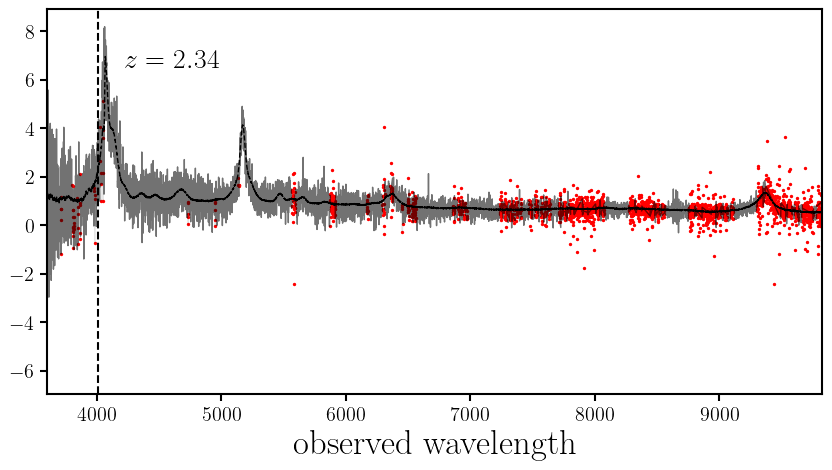

tensor(2.0933e+08)
BATCH 60
tensor(2.5552e+08)


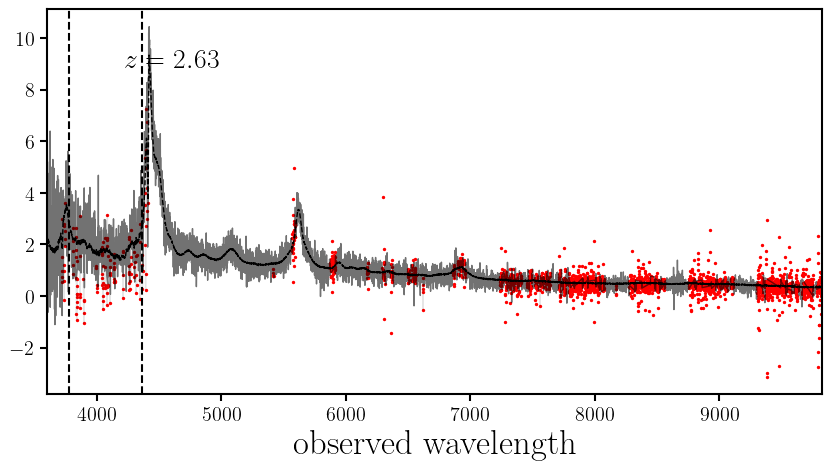

tensor(2.5180e+08)
BATCH 61
tensor(3.1638e+08)


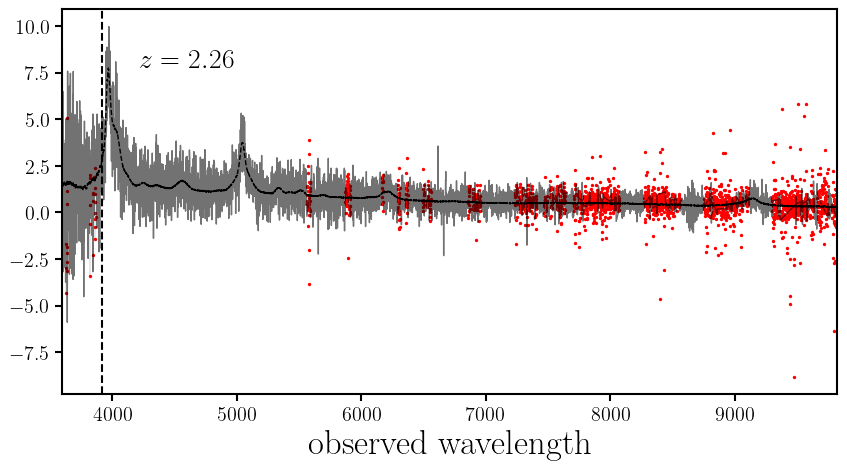

tensor(3.1086e+08)
BATCH 62
tensor(2.0346e+08)


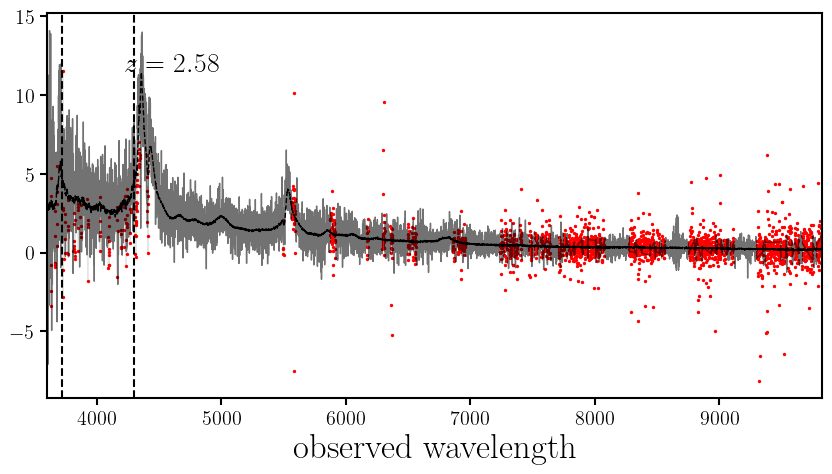

tensor(2.0145e+08)
BATCH 63
tensor(2.5343e+08)


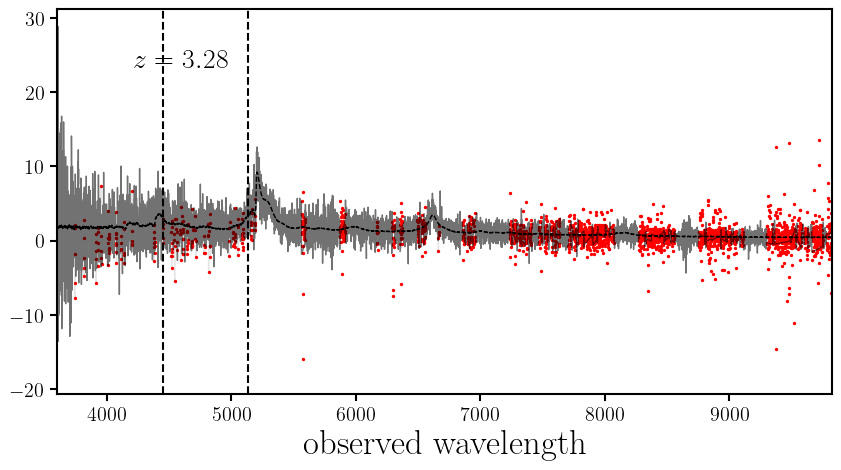

tensor(2.4573e+08)
BATCH 64
tensor(2.0210e+08)


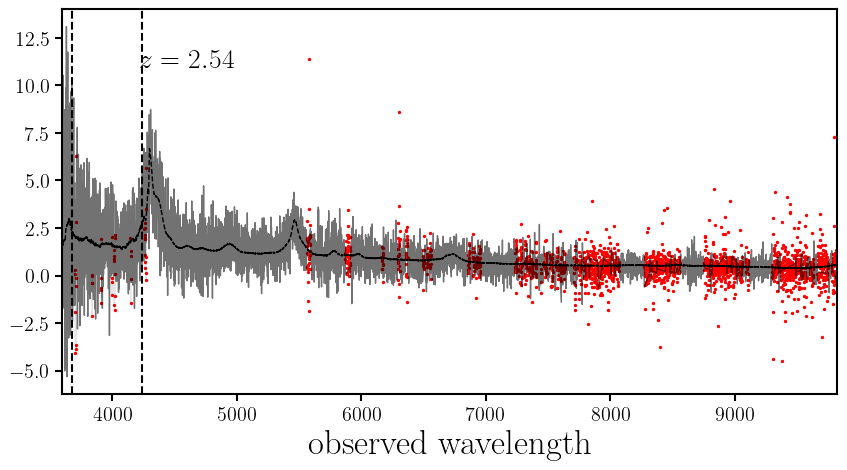

tensor(1.9783e+08)
BATCH 65
tensor(2.0228e+08)


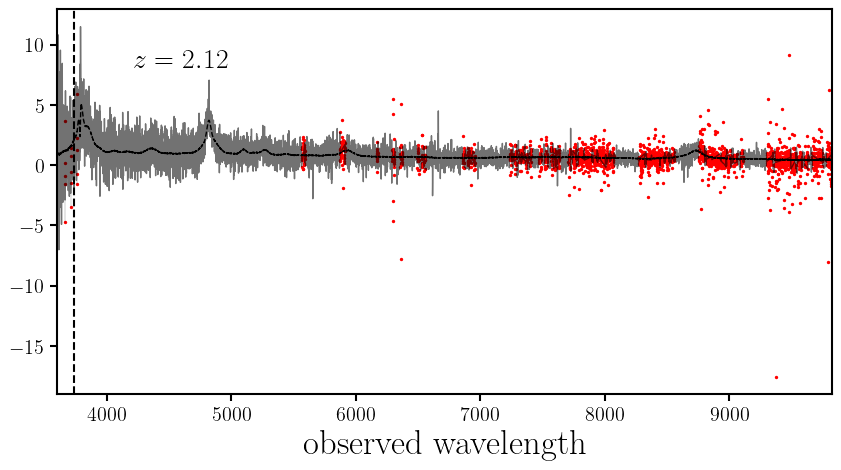

tensor(2.0029e+08)
BATCH 66
tensor(2.3591e+08)


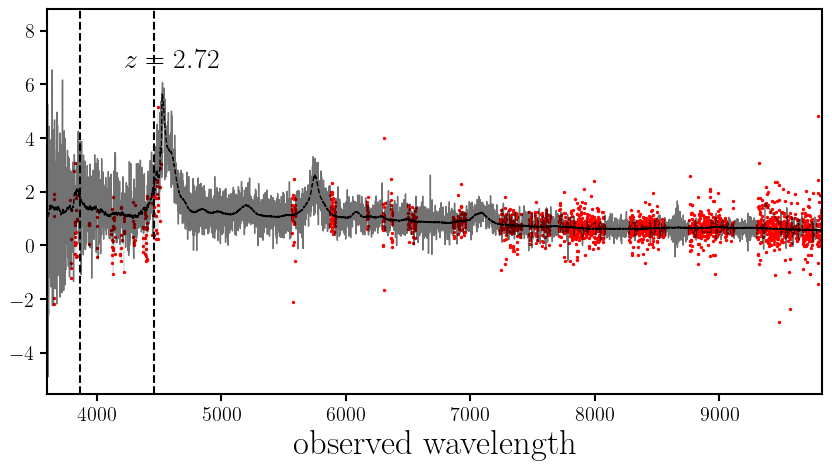

tensor(2.2135e+08)
BATCH 67
tensor(2.9065e+08)


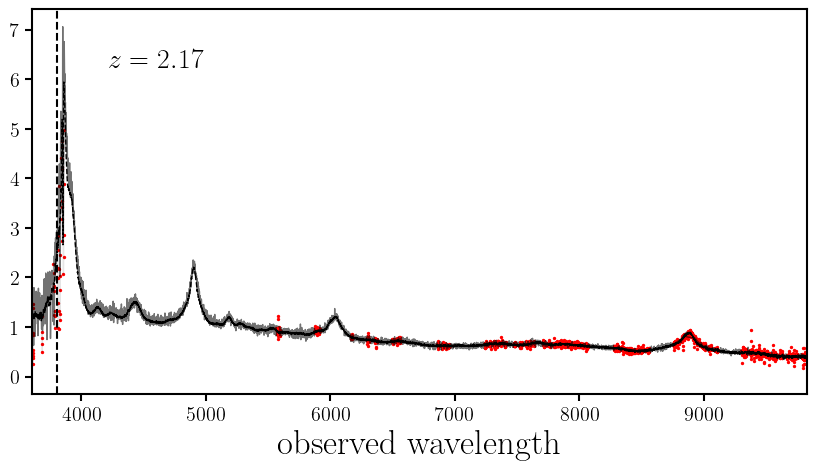

tensor(2.8790e+08)
BATCH 68
tensor(2.0760e+08)


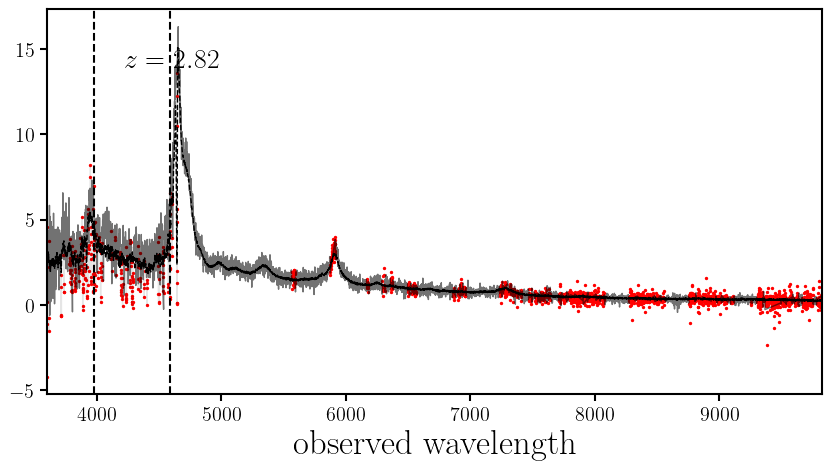

tensor(2.0425e+08)
BATCH 69
tensor(1.9806e+08)


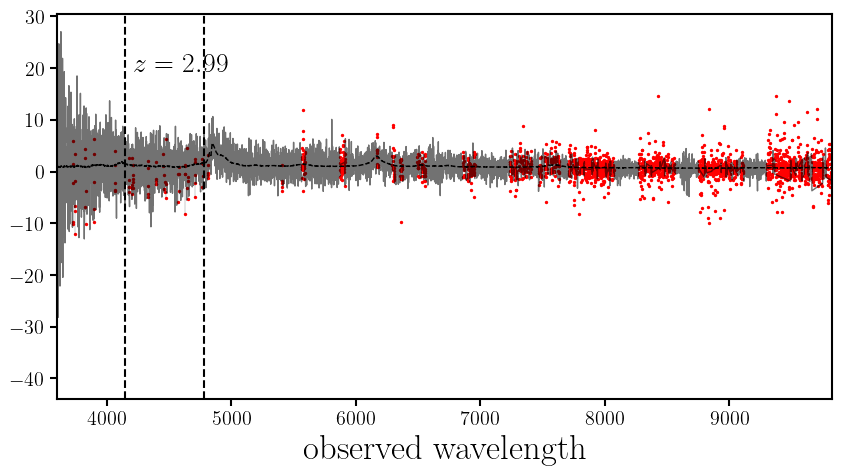

tensor(1.9496e+08)
BATCH 70
tensor(3.6925e+08)


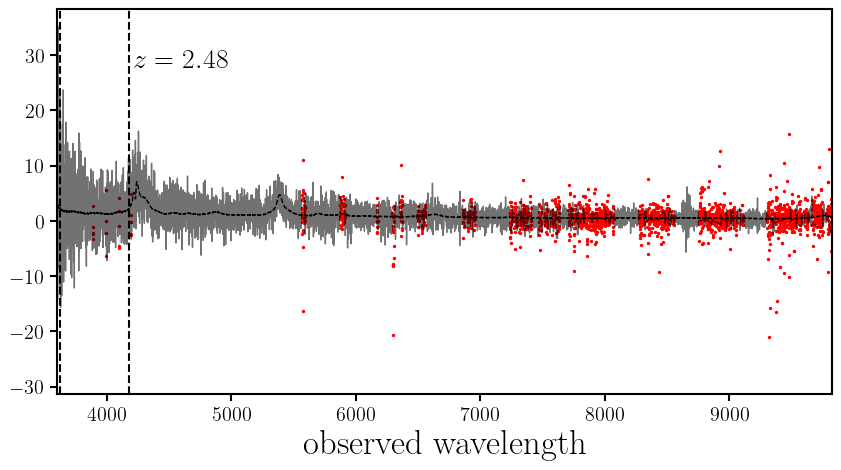

tensor(3.6339e+08)
BATCH 71
tensor(2.0876e+08)


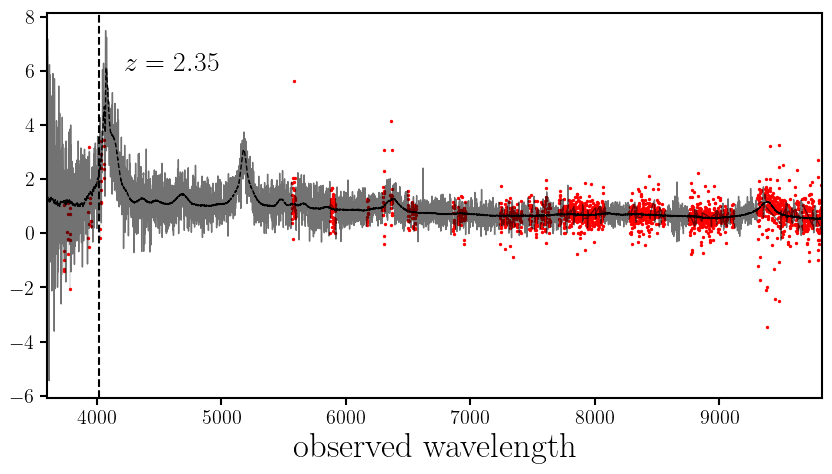

tensor(2.0713e+08)
BATCH 72
tensor(2.4438e+08)


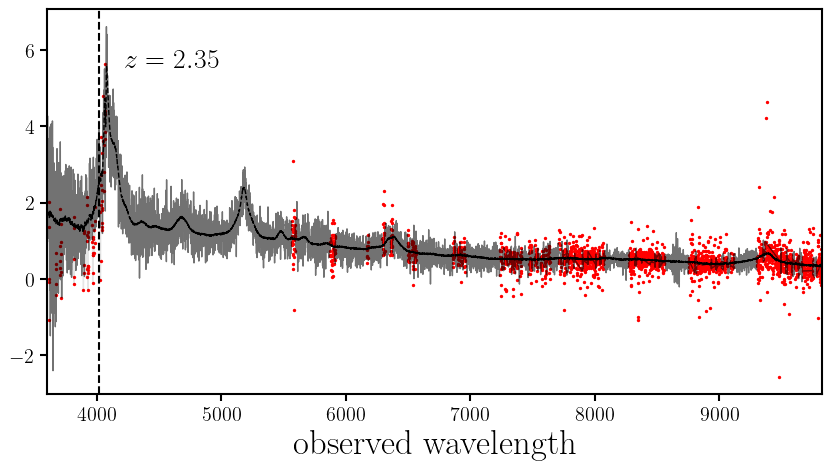

tensor(2.4008e+08)
BATCH 73
tensor(1.6918e+08)


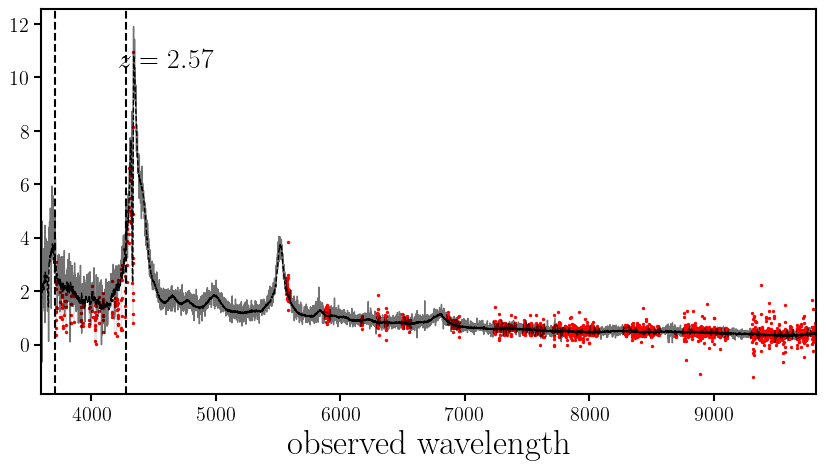

tensor(1.6769e+08)
BATCH 74
tensor(2.2029e+08)


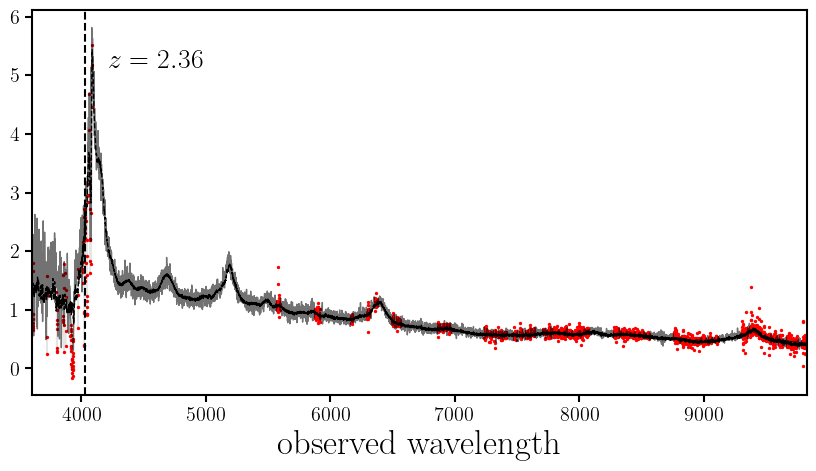

tensor(2.1816e+08)
BATCH 75
tensor(2.3857e+08)


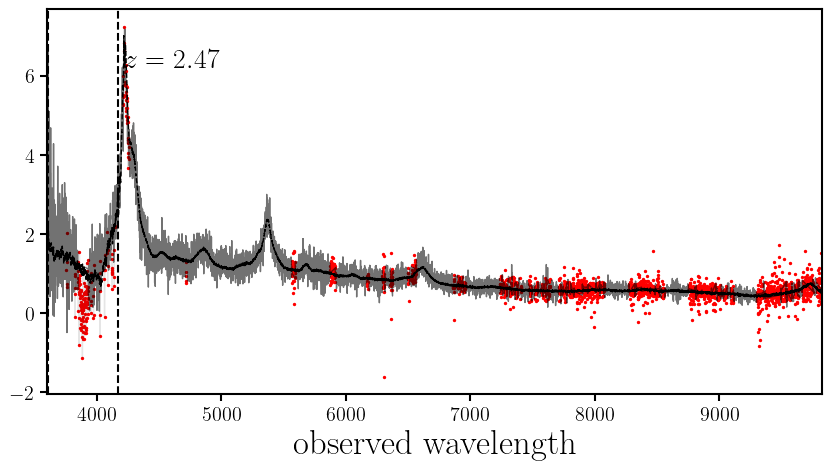

tensor(2.3590e+08)
BATCH 76
tensor(1.5516e+08)


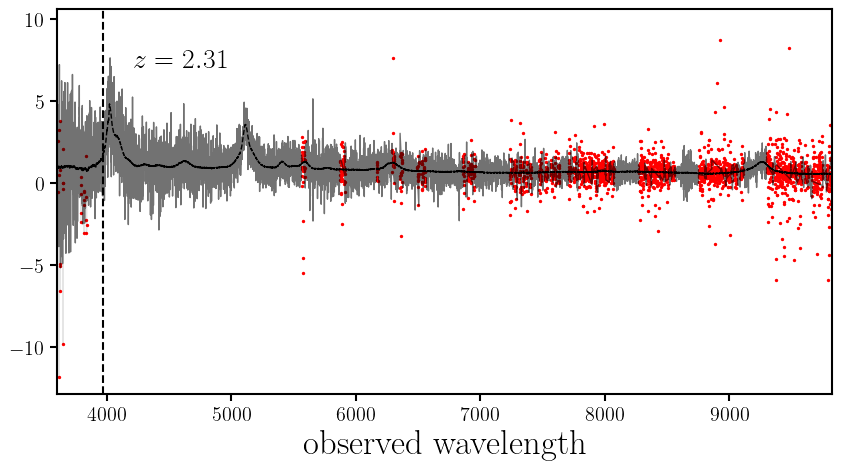

tensor(1.5396e+08)
BATCH 77
tensor(2.5702e+08)


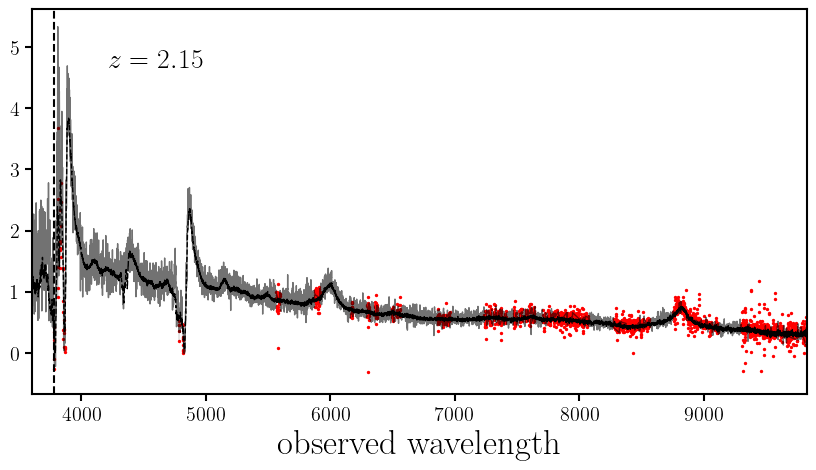

tensor(2.5277e+08)
BATCH 78
tensor(1.5188e+08)


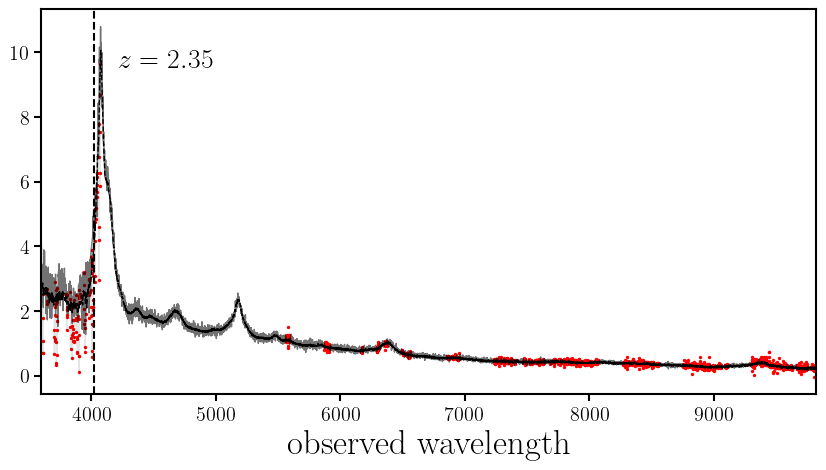

tensor(1.4999e+08)
BATCH 79
tensor(3.0836e+08)


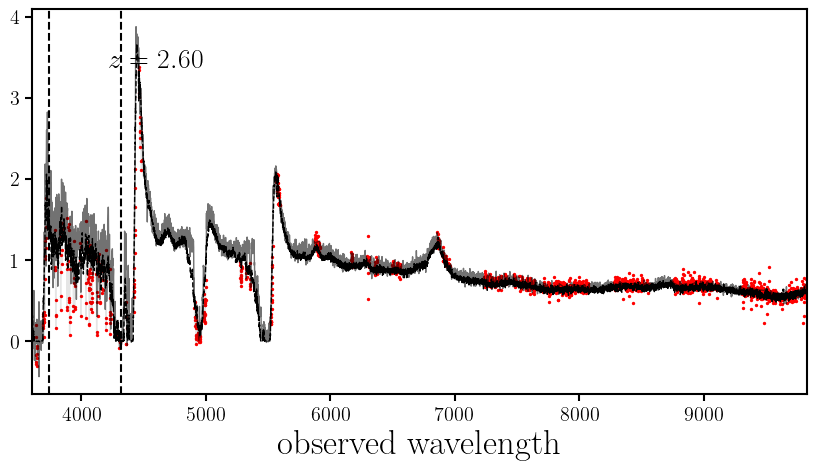

tensor(2.9066e+08)
BATCH 80
tensor(2.6379e+08)


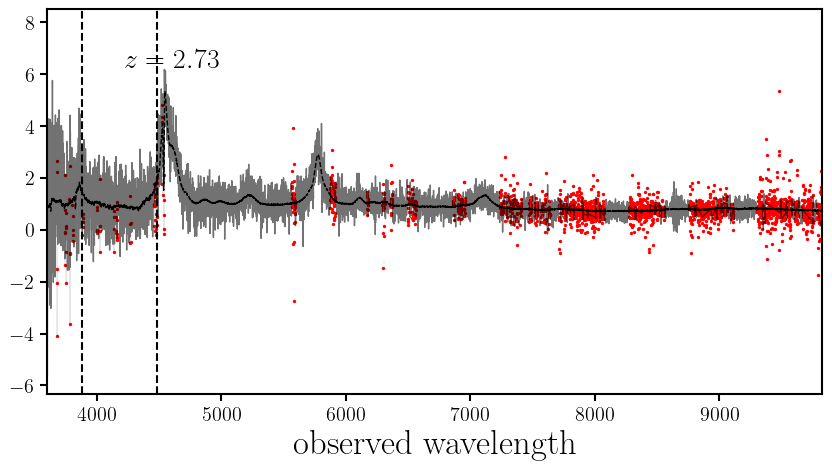

tensor(2.6041e+08)
BATCH 81
tensor(1.9784e+08)


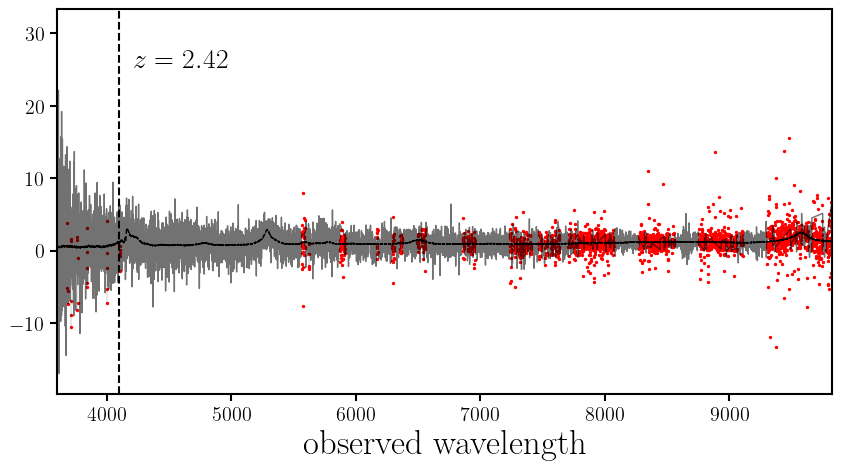

tensor(1.9591e+08)
BATCH 82
tensor(2.7394e+08)


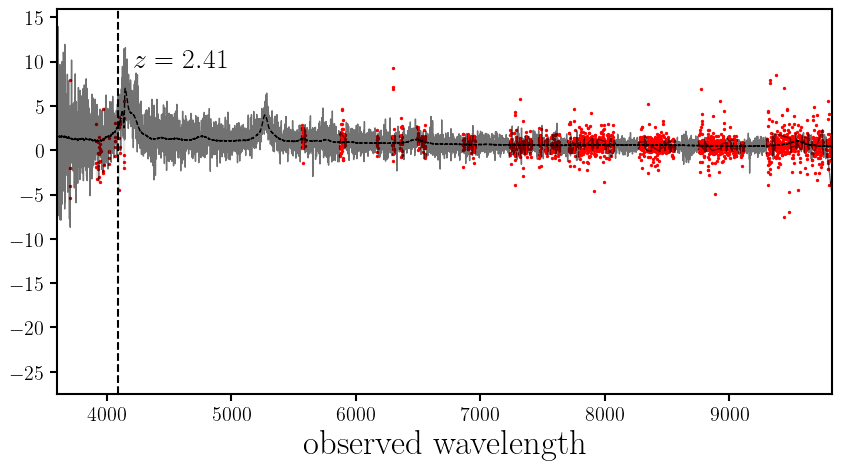

tensor(2.5576e+08)
BATCH 83
tensor(1.9646e+08)


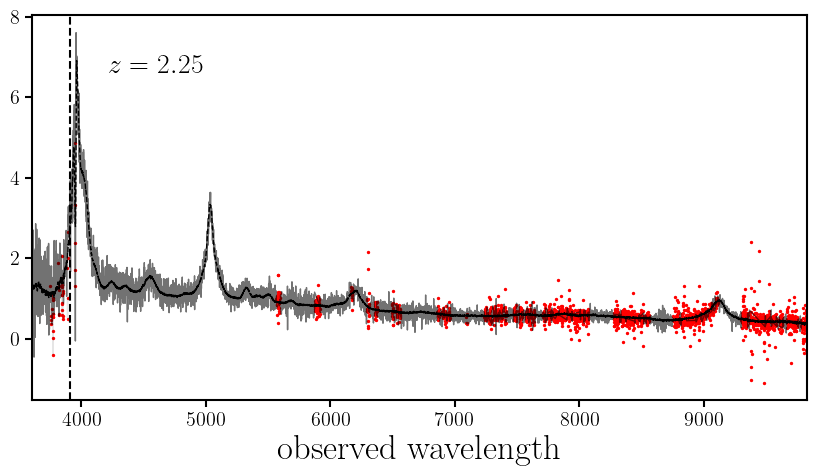

tensor(1.9432e+08)
BATCH 84
tensor(2.0868e+08)


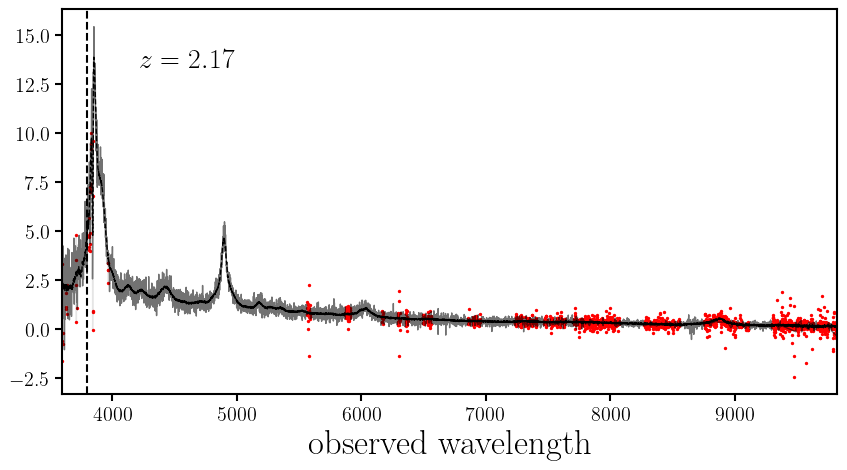

tensor(2.0656e+08)
BATCH 85
tensor(2.8075e+08)


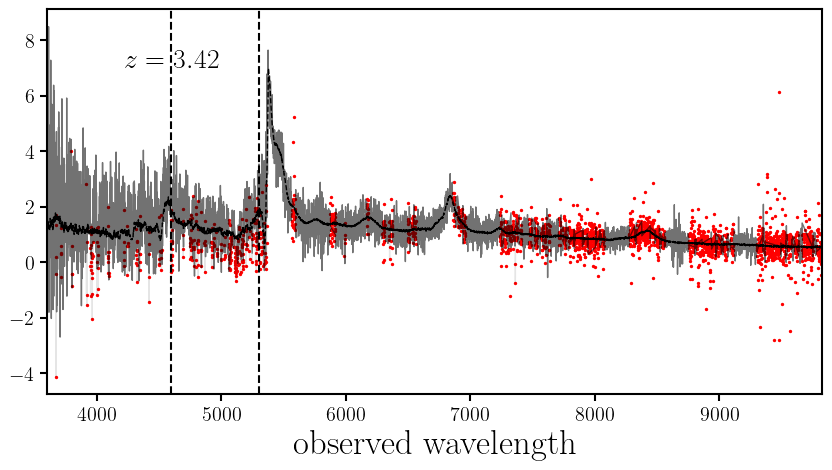

tensor(2.7802e+08)
BATCH 86
tensor(1.7884e+08)


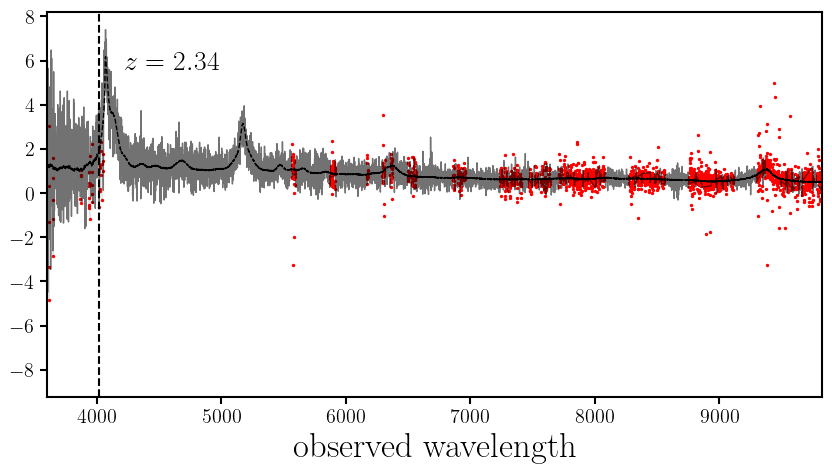

tensor(1.7691e+08)
BATCH 87
tensor(3.2844e+08)


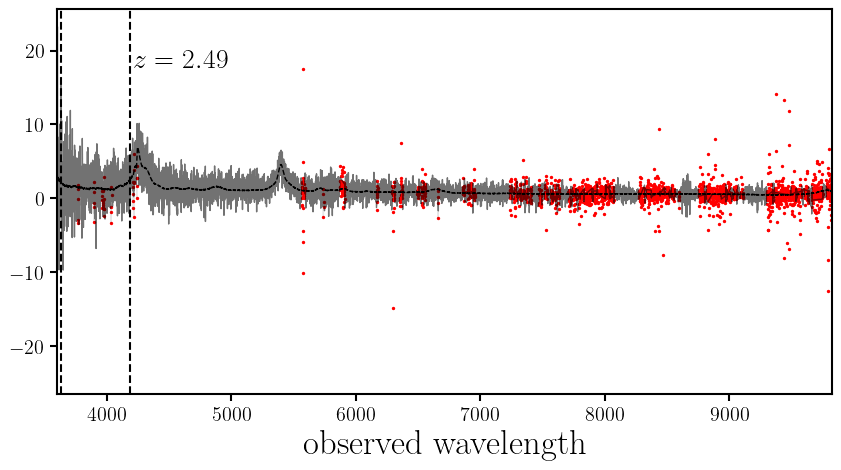

tensor(3.2373e+08)
BATCH 88
tensor(2.2762e+08)


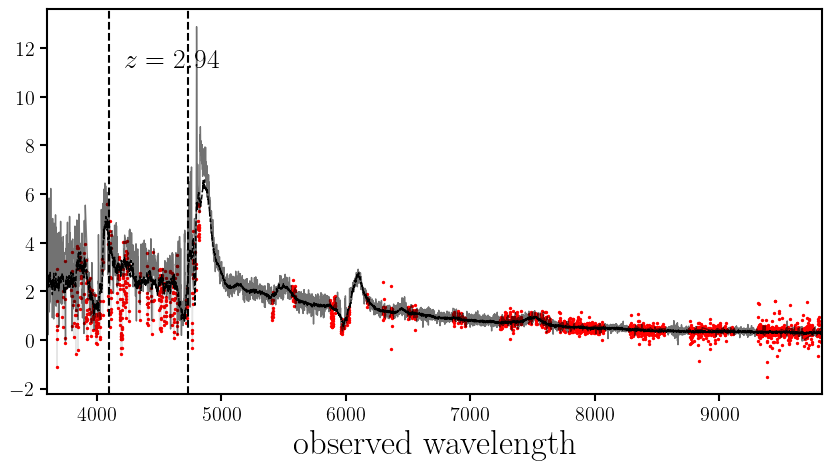

tensor(2.2479e+08)
BATCH 89
tensor(2.2791e+08)


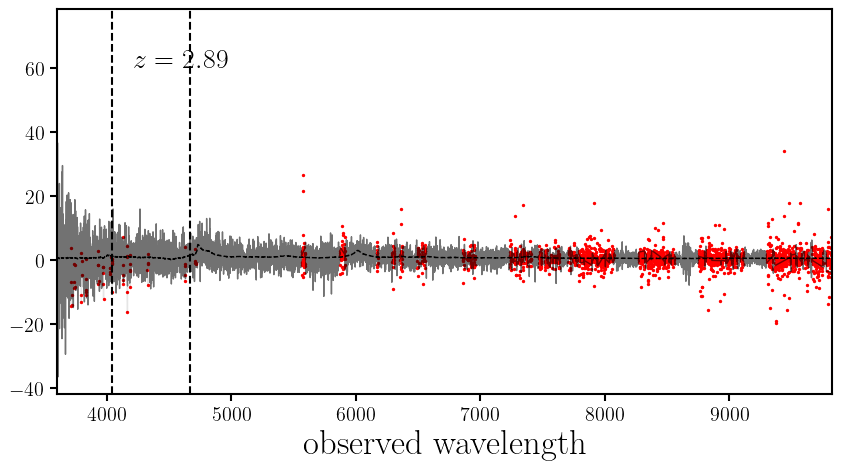

tensor(2.2564e+08)
BATCH 90
tensor(1.9265e+08)


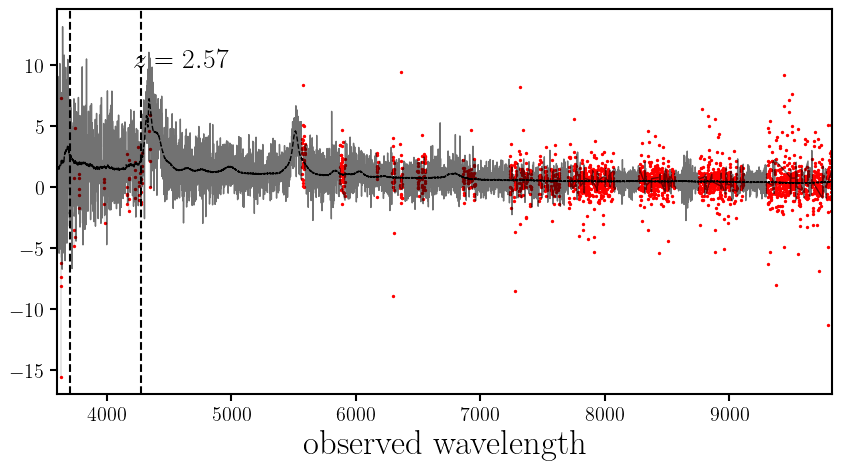

tensor(1.9038e+08)
BATCH 91
tensor(2.7684e+08)


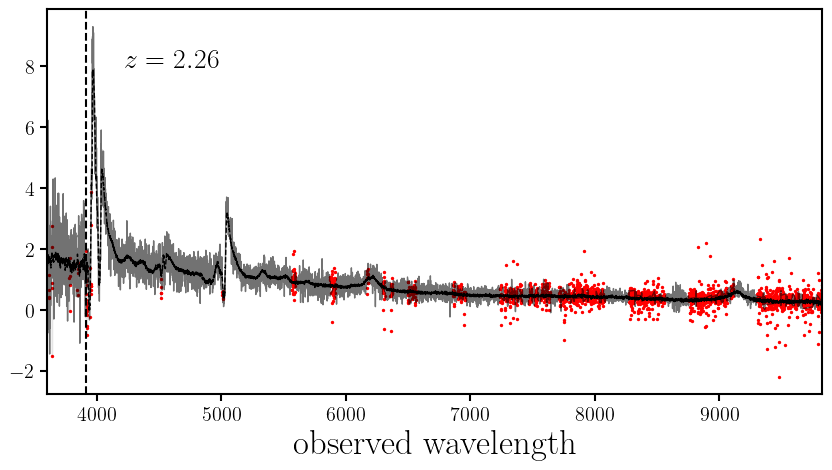

tensor(2.7045e+08)
BATCH 92
tensor(1.9759e+08)


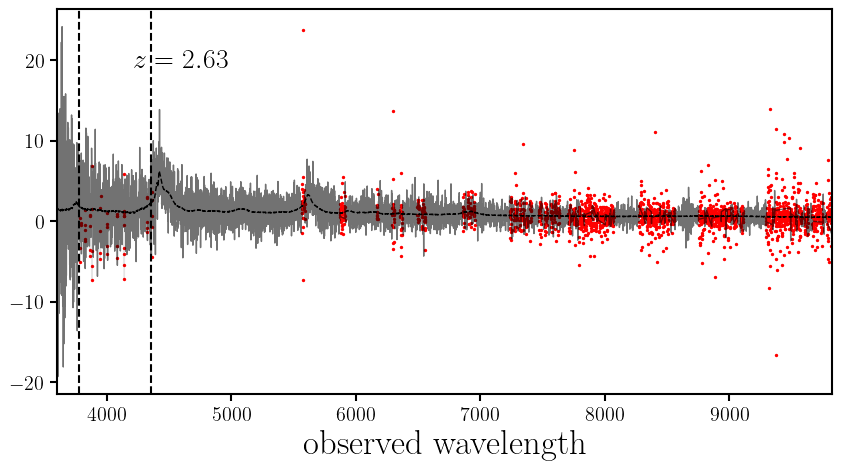

tensor(1.9446e+08)
BATCH 93
tensor(2.3551e+08)


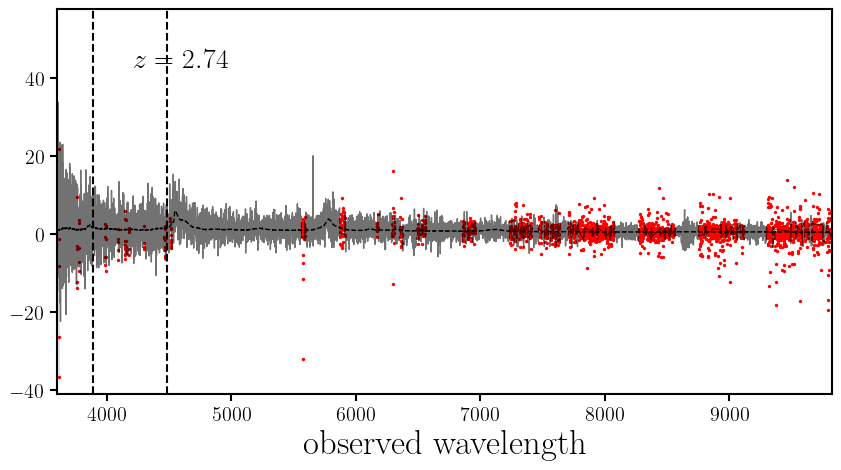

tensor(2.3177e+08)
BATCH 94
tensor(2.4755e+08)


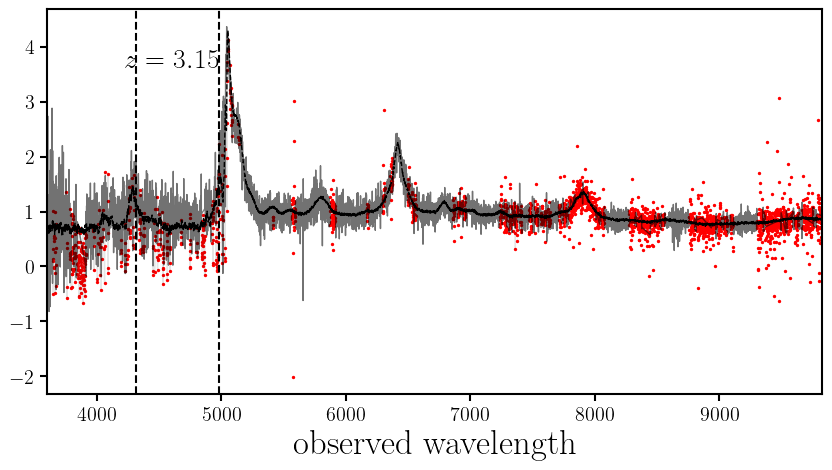

tensor(2.4309e+08)
BATCH 95
tensor(2.2196e+08)


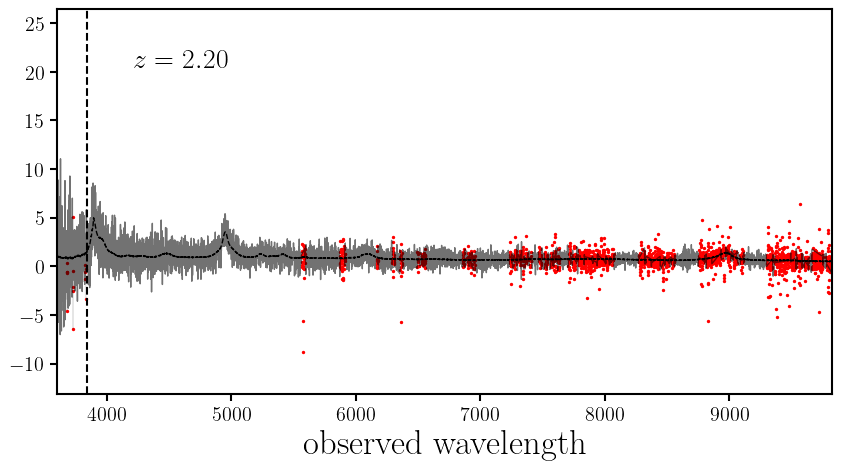

tensor(2.1957e+08)
BATCH 96
tensor(2.4210e+08)


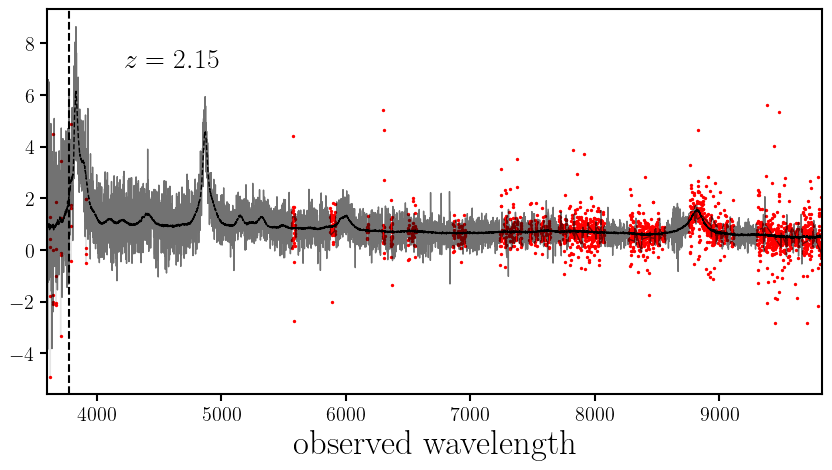

tensor(2.3848e+08)
BATCH 97
tensor(2.8899e+08)


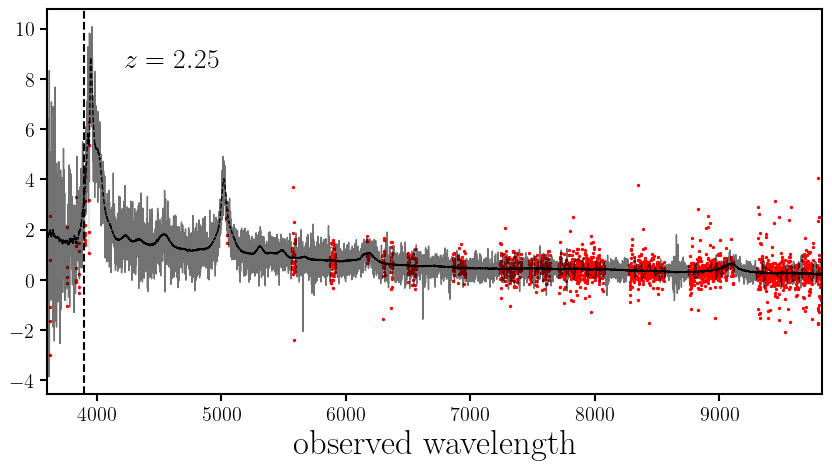

tensor(2.8009e+08)
BATCH 98
tensor(2.8742e+08)


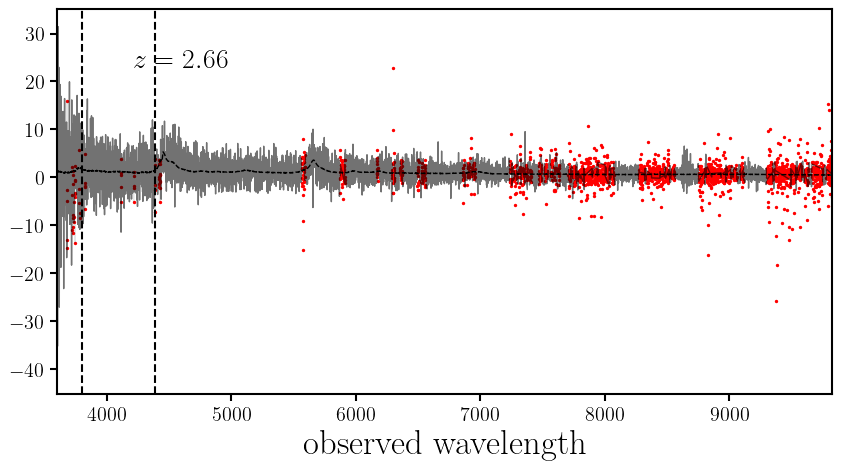

tensor(2.8404e+08)
BATCH 99
tensor(5.2444e+08)


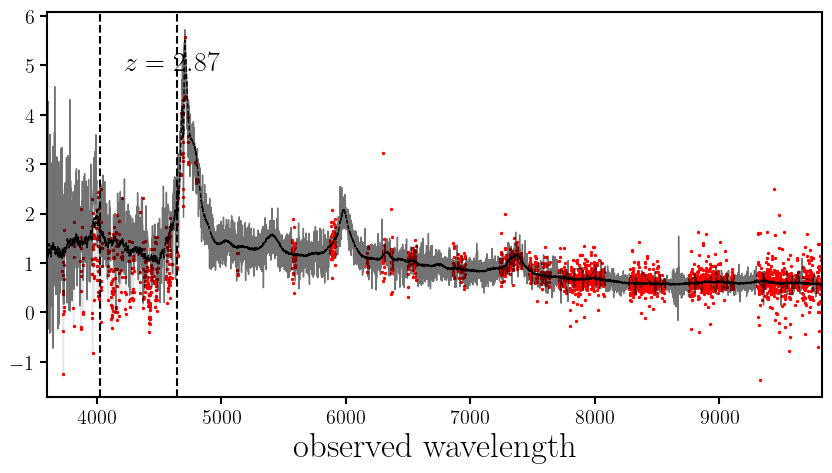

tensor(5.1164e+08)


In [22]:
for ibatch in range(19,100): 
    print('BATCH %i' % ibatch)
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % ibatch, "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    #true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))
    
    with torch.no_grad():
        models[0].eval()
        instruments[0].eval()

        s = models[0].encode(spec)
        spec_rest = models[0].decode(s)
        
    # check for reconstruction accuracy
    #is_good = [] 
    #for igal in range(spec.shape[0]):
    #    if z[igal] > 3.499: # quick fix for some wavelength issue
    #        is_good.append(False)
    #        continue
    #    is_good.append(good_recon(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), 
    #                                   np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]),   
    #                                   z[igal].item(), thresholds=[10, 0.1], verbose=False))
    #is_good = np.array(is_good)        
    #print(np.sum(~is_good))
    #if np.sum(is_good) == len(is_good): raise ValueError
    
    # identify LyA absorption
    print(w.sum())
    for igal in np.arange(spec.shape[0]): 
        is_absorb = identify_LyA(
            np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
            np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), sigma=1.5)
        
        if igal == 100: 
            fig = plt.figure(figsize=(10,5))
            sub = fig.add_subplot(111)
            sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
            sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='k', lw=1, ls='--', label='Reconst.')
        
            #sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
            sub.plot(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', alpha=0.5, lw=1, label='Observed')    
            sub.scatter(models[0].wave_obs[(w[igal] == 0) | is_absorb], spec[igal][(w[igal] == 0) | is_absorb], c='r', s=2)
            
            sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
            sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')

            sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)

            sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])
    
            sub.set_xlabel("observed wavelength", fontsize=25)
            plt.show()
            
        # update weights
        w[igal,is_absorb] = 0.
    print(w.sum())
        
    batch = [spec, w, z, target_id, norm, zerr]
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter0_%i.pkl' % ibatch, "wb") as f:
        pickle.dump(batch, f)